# Evaluating our Embedding Latent Spaces

In [1]:
import pandas as pd
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns

import gcsfs
import os
import json
import time
import sys

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

fs = gcsfs.GCSFileSystem()

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Load Model to analyze

In [3]:
#from Architectures.VAE import VariationalAutoencoder
from utils2 import load_vars_xarray, split_input_output, load_model

In [4]:
class VariationalEncoder(torch.nn.Module):
    """
    Conditional VAE Encoder with <layers>+1 fully connected layer
    """
    def __init__(self, in_dims, hidden_dims=[128, 128, 64, 32], latent_dims=5, layers=4, dropout=0, device='cuda'):
        super().__init__()
        self.linears = [torch.nn.Sequential(
                torch.nn.Linear(in_dims, hidden_dims[0]),
                torch.nn.LayerNorm(hidden_dims[0]),
                torch.nn.Dropout(p=dropout))]
        self.add_module('linear0', self.linears[-1])
        for i in range(1, layers):
            self.linears += [torch.nn.Sequential(
                torch.nn.Linear(hidden_dims[i-1], hidden_dims[i]),
                torch.nn.LayerNorm(hidden_dims[i]),
                torch.nn.Dropout(p=dropout))
                ]
            self.add_module('linear%d' % i, self.linears[-1])
        self.linear_mean = torch.nn.Linear(hidden_dims[-1], latent_dims)
        self.linear_logstd = torch.nn.Linear(hidden_dims[-1], latent_dims) # log of actual, later exponentiate

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device)
        self.N.scale = self.N.scale.to(device)
        self.kl = 0
        
        self.device = device
        
    def forward(self, x, return_latent=False):
        if(len(x.shape) > 1):
            x = torch.flatten(x, start_dim=1)
        for linear in self.linears:
            x = torch.nn.functional.relu(linear(x))
        mu = self.linear_mean(x) # mu is g(l(x))
        if return_latent:
            return mu
        else:
            sigma = torch.exp(self.linear_logstd(x)) # sigma is h(l(x))
            z = mu + sigma * self.N.sample(mu.shape) # reparameterization trick
            self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).mean()
            return z

class Decoder(torch.nn.Module):
    """
    Conditional VAE Decoder with <layers>+1 fully connected layer
    """
    def __init__(self, out_dims, hidden_dims=[32, 64, 128, 128], latent_dims=3, layers=4, dropout=0):
        super().__init__()
        self.linears = [torch.nn.Sequential(
                torch.nn.Linear(latent_dims, hidden_dims[0]),
                torch.nn.LayerNorm(hidden_dims[0]),
                torch.nn.Dropout(p=dropout))]
        self.add_module('linear0', self.linears[-1])
        
        for i in range(1, layers):
            self.linears += [torch.nn.Sequential(
                torch.nn.Linear(hidden_dims[i-1], hidden_dims[i]),
                torch.nn.LayerNorm(hidden_dims[i]),
                torch.nn.Dropout(p=dropout))
                ]
            self.add_module('linear%d' % i, self.linears[-1])        

        self.final_linear1 = torch.nn.Linear(hidden_dims[-1], out_dims)
        # self.final_linear2 = torch.nn.Linear(hidden_dims, out_dims)
        self.final_log_std1 = torch.nn.Linear(hidden_dims[-1], out_dims)
        # self.final_lambda = torch.nn.Linear(hidden_dims, 1)
        # self.final_prob_zero = torch.nn.Linear(hidden_dims, out_dims)

    def forward(self, z): # outputs distribution
        for linear in self.linears:
            z = torch.nn.functional.relu(linear(z))
        m1 = self.final_linear1(z)
        # m2 = self.final_linear2(z)
        #s1 = torch.exp(self.final_log_std1(z))

        return m1#, s1
    
    
class VariationalEncoderDecoder(torch.nn.Module):
    def __init__(self, model_params):
        super().__init__()
        self.data_dims = model_params['data_dims']
        self.label_dims = model_params['label_dims']
        self.latent_dims = model_params['latent_dims']
        self.device = model_params['device']
        dropout = model_params['dropout']

        # Encoder - compresses data into latent dims
        self.encoder = VariationalEncoder(self.data_dims, model_params['input_layers'], self.latent_dims, 
                       len(model_params['input_layers']), dropout).to(self.device)

        # Decoder - tries to learn both input and output variables. 
        self.decoder = Decoder(self.label_dims + self.data_dims, model_params['output_layers'], self.latent_dims, 
                               layers=len(model_params['output_layers']), dropout=dropout).to(self.device)
        #self.beta = model_params['beta']
        
        self.losses = []

    def forward(self, x, return_latent=False):
        # expect to be batch_size x data_dims matrix and y to be batch_size x label_dims matrix
        
        z = self.encoder(x, return_latent)
        if return_latent:
            return z
        #O_hat_mu, O_hat_std = self.decoder(z)
        return self.decoder(z)

In [5]:
def load_model(name, baseDir = 'saved_data/models', load_weights=True):
    path = os.path.join(baseDir, name)
    params = json.load(open(path + '.json'))
    model_params = params['model_parameters']
    architecture = model_params['architecture']
    match architecture.lower():
        case "ved":
            model = VariationalEncoderDecoder(model_params)
        case "vae":
            print("VAE loading not implemented")
        case "cvae":
            model = ConditionalVAE(model_params['beta'], model_params['data_dims'], model_params['label_dims'], dropout=model_params['dropout'],
                 latent_dims=model_params['latent_dims'], hidden_dims=model_params['hidden_dims'], layers=model_params['layers']).to(model_params['device'])
        case _:
            print("Unknown architecture")
    if(load_weights): # load not just architecture but weights. Do unless training went terribly
        model.load_state_dict(torch.load(path + params['save_parameters']['filetype']))
    model.eval()

    return(model, params)

In [7]:
baseDir = 'saved_data/models/'
name = 'VED_trial3_npy'
model, params = load_model(name, baseDir, load_weights=False)

In [201]:
model.encoder.linears[0][0].weight

Parameter containing:
tensor([[-0.0744,  0.0678, -0.0570,  ..., -0.0275, -0.1273, -0.0162],
        [-0.1306,  0.0653, -0.0722,  ..., -0.0276,  0.1198, -0.1154],
        [ 0.0712,  0.0391,  0.1223,  ...,  0.1303, -0.0010, -0.1448],
        ...,
        [-0.0288,  0.0780,  0.1208,  ..., -0.1112, -0.1212,  0.1458],
        [ 0.0649,  0.1073,  0.1214,  ...,  0.0886, -0.1102, -0.0280],
        [-0.0728,  0.1051,  0.0370,  ..., -0.1221, -0.1185,  0.0469]],
       device='cuda:0', requires_grad=True)

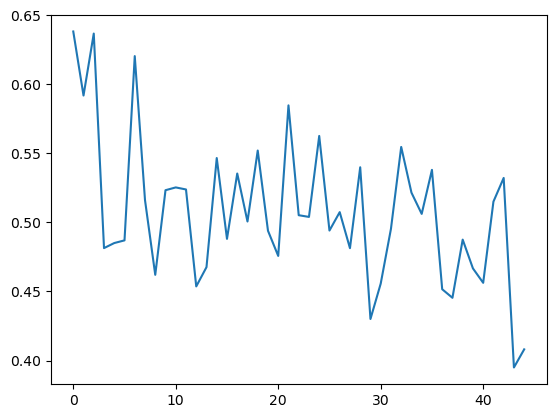

In [8]:
plt.plot(params['info']['losses'])

### Load Data

In [6]:
from dask.diagnostics import ProgressBar

In [7]:
# same variables as VED paper
# humidity, temp, solar insolation, latent and sensible heat, surface pressure
input_vars = 'state_q0001 state_t pbuf_SOLIN pbuf_LHFLX pbuf_SHFLX state_ps'.split()
output_vars = ['state_q0001', 'state_t', 'cam_out_NETSW', 'cam_out_FLWDS', 'cam_out_PRECC']

ds = load_vars_xarray(input_vars, output_vars, downsample=True, chunks = True)
selected_levels = np.append(np.linspace(4, 24, 6), np.linspace(26, 59, 14)).astype(np.int32)
ds = ds.isel(lev=selected_levels)

#ds = ds.isel(time = slice(0, 4*365), ncol=slice(0, 16))

from dask.diagnostics import ProgressBar

# visualize with progress bar
# use .load() or .compute() to do the math and get the daily mean data

with ProgressBar():
    ds.load()

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/dataset.py:255: UserWarning: The specified Dask chunks separate the stored chunks along dimension "sample" starting at index 720. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


Daily average
[########################################] | 100% Completed | 23m 40s


In [10]:
selected_levels = list(selected_levels)
selected_levels

[4, 8, 12, 16, 20, 24, 26, 28, 31, 33, 36, 38, 41, 43, 46, 48, 51, 53, 56, 59]

In [11]:
def normalize(xarr):
    var_means = xarr.mean(dim=['time', 'ncol'])
    var_stds = xarr.std(dim=['time', 'ncol'])
    arr = (xarr - var_means) / var_stds
    
    means = []
    stds = []
    for var in arr.data_vars:
        means.append(var_means[var].values.reshape(-1, 1))
        stds.append(var_stds[var].values.reshape(-1, 1))
    return(arr, np.vstack(means)[:, 0], np.vstack(stds)[:,0])

class MyDataset(Dataset):
    def __init__(self, ds, device = "cuda" if torch.cuda.is_available() else "cpu"):
        self.ds = ds
        self.X_ds, self.Y_ds = split_input_output(ds)
        self.device = device
        
        #self.X_norm, self.X_mean, self.X_std = normalize(self.X_ds)
        #self.Y_norm, self.Y_mean, self.Y_std = normalize(self.Y_ds)
        
    def __len__(self):
        return( self.ds.time.size * self.ds.ncol.size )
    
    def __getitem__(self, idx):
        t, col = idx // self.ds.ncol.size, idx % self.ds.ncol.size
        X = self.X_ds.isel(time=t, ncol=[col])
        Y = self.Y_ds.isel(time=t, ncol=[col])
        
        X = X.to_stacked_array("v", sample_dims=["ncol"]).values
        Y = Y.to_stacked_array("v", sample_dims=["ncol"]).values
        
        X = torch.as_tensor(X, device=self.device, dtype=torch.float32)
        Y = torch.as_tensor(Y, device=self.device, dtype=torch.float32)
        return(X.flatten(), Y.flatten())

In [12]:
def select_region(ds, condition):
    # assumes condition is a lambda function taking in a lat and lon
    # returns the indices for which this is true
    lat, lon = ds.lat.values, ds.lon.values
    latlon = pd.DataFrame({"lat" : lat, "lon": lon})
    return(list(latlon[latlon.apply(condition, axis=1)].index)) # the indices of the matching latlons

def split_ds_by_area(ds, condition):
    match = select_region(ds, condition)
    unmatch = select_region(ds, lambda row : not condition(row))
    return(ds.isel(ncol=match), ds.isel(ncol=unmatch))

In [14]:
ds

<xarray.Dataset>
Dimensions:            (time: 2920, lev: 20, ncol: 384)
Coordinates:
  * time               (time) object 0001-02-01 12:00:00 ... 0009-01-31 12:00:00
  * ncol               (ncol) int64 0 1 2 3 4 5 6 ... 378 379 380 381 382 383
    lat                (ncol) float64 -32.59 -35.99 -22.69 ... 45.34 45.34 40.39
    lon                (ncol) float64 -39.73 -28.47 -39.56 ... 123.3 146.7 135.0
Dimensions without coordinates: lev
Data variables:
    state_q0001        (time, lev, ncol) float64 1.424e-06 ... 0.003413
    state_t            (time, lev, ncol) float64 257.8 258.9 ... 265.4 275.4
    pbuf_SOLIN         (time, ncol) float64 477.9 475.6 476.4 ... 163.8 198.4
    pbuf_LHFLX         (time, ncol) float64 77.19 113.1 184.8 ... 96.89 28.51
    pbuf_SHFLX         (time, ncol) float64 3.864 9.653 51.89 ... 123.3 12.17
    state_ps           (time, ncol) float64 1.011e+05 1.013e+05 ... 1.006e+05
    out_state_q0001    (time, lev, ncol) float64 1.424e-06 ... 0.003416
    out_state_t        (time, lev, ncol) float64 257.8 258.9 ... 265.2 275.4
    out_cam_out_NETSW  (time, ncol) float64 332.9 313.0 243.3 ... 69.06 79.14
    out_cam_out_FLWDS  (time, ncol) float64 354.8 339.1 399.6 ... 243.8 285.2
    out_cam_out_PRECC  (time, ncol) float64 2.325e-11 1.05e-09 ... 5.284e-09
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

In [511]:
ds_norm, ds_mu, ds_sigma = normalize(ds)
train = ds_norm.isel(time = slice(0, 7*365 + 1), ncol=select_region(ds, lambda row : abs(row.lat) < 10))
test = ds_norm.isel(time = slice(7*365 + 1, 8*365), ncol=select_region(ds, lambda row : abs(row.lat) < 10))
X_train_xarr, Y_train_xarr = split_input_output(train)
X_test_xarr, Y_test_xarr = split_input_output(test)

In [514]:
X_test_np.shape

(23296, 44)

In [512]:
X_train_np = X_train_xarr.to_stacked_array("v", sample_dims=["ncol", 'time']).values.reshape(-1, 44)
Y_train_np = Y_train_xarr.to_stacked_array("v", sample_dims=["ncol", 'time']).values.reshape(-1, 43)
X_test_np = X_test_xarr.to_stacked_array("v", sample_dims=["ncol", 'time']).values.reshape(-1, 44)
Y_test_np = Y_test_xarr.to_stacked_array("v", sample_dims=["ncol", 'time']).values.reshape(-1, 43)

In [20]:
train_dataset = MyDataset(train, device)
test_dataset = MyDataset(test, device)

In [23]:
def get_O_indices(variable, lev=59):
    # gets concat output index of given variable
    assert lev in selected_levels, "Level value not in selected values, please choose again"
    axis=train.to_stacked_array("v", sample_dims=["ncol", 'time'])
    vals = pd.Series(axis.v.values)
    index_var = vals[vals.apply(lambda row : row[0] == variable)].index
    if(len(index_var)==1):
        return(index_var[0]) # non leveled
    lev_index = selected_levels.index(lev)     
    return(index_var[lev_index])

In [ ]:
83

In [496]:
get_O_indices('out_cam_out_PRECC', 59)

86

In [28]:
def get_item_value(xarr, index, variable, level_value=59):
    # xarr should either be train or test. 
    # if level variable can specify which level; default is surface but doesn't matter
    assert level_value in selected_levels, "Level value not in selected values, please choose again"
    assert index < xarr.time.size * xarr.ncol.size, "Index is outside of range"
    
    lev_index = selected_levels.index(level_value)     
    t, col = index // xarr.ncol.size, index % xarr.ncol.size
    val = xarr.isel(lev=lev_index, time=t, ncol=col)[variable]
    stat_index = get_O_indices(variable, level_value)
    return(val * ds_sigma[stat_index] + ds_mu[stat_index])

In [40]:
def get_item_values(xarr, indices, variable, level_value=59):
    # xarr should either be train or test. 
    # if level variable can specify which level; default is surface but doesn't matter
    indices = np.array(indices)
    assert level_value in selected_levels, "Level value not in selected values, please choose again"
    assert indices.max() < xarr.time.size * xarr.ncol.size, "Index is outside of range"
    
    lev_index = selected_levels.index(level_value)
    ts, cols = indices // xarr.ncol.size, indices % xarr.ncol.size
    vals = xarr.isel(lev=lev_index, time=ts, ncol=cols)[variable].values.diagonal()
    
    stat_index = get_O_indices(variable, level_value)
    return(vals * ds_sigma[stat_index] + ds_mu[stat_index])

In [42]:
get_O_indices('state_t', 59)

39

In [497]:
test

<xarray.Dataset>
Dimensions:            (time: 364, ncol: 64, lev: 20)
Coordinates:
  * time               (time) object 0008-02-02 12:00:00 ... 0009-01-31 12:00:00
  * ncol               (ncol) int64 18 19 22 23 26 27 ... 229 232 233 236 237
    lat                (ncol) float64 -4.43 -5.01 -5.41 -5.61 ... 5.41 5.01 4.43
    lon                (ncol) float64 -39.4 -28.15 -16.89 ... -61.85 -50.6
Dimensions without coordinates: lev
Data variables:
    state_q0001        (time, lev, ncol) float64 0.9061 0.9048 ... 0.7871 0.7784
    state_t            (time, lev, ncol) float64 0.8554 0.6009 ... 0.9674 0.8621
    pbuf_SOLIN         (time, ncol) float64 0.7599 0.773 ... 0.4913 0.5096
    pbuf_LHFLX         (time, ncol) float64 0.4588 0.3838 ... -0.7954 0.2793
    pbuf_SHFLX         (time, ncol) float64 -0.4393 -0.1566 ... 1.963 0.3117
    state_ps           (time, ncol) float64 0.1988 0.4806 ... 0.03356 0.3592
    out_state_q0001    (time, lev, ncol) float64 0.9061 0.9048 ... 0.7908 0.7777
    out_state_t        (time, lev, ncol) float64 0.8551 0.6017 ... 0.9694 0.8649
    out_cam_out_NETSW  (time, ncol) float64 -0.3796 -0.4592 ... -0.09355 0.1072
    out_cam_out_FLWDS  (time, ncol) float64 1.13 1.111 0.8737 ... 1.178 1.17
    out_cam_out_PRECC  (time, ncol) float64 -0.4137 2.544 ... -0.4148 -0.4159

In [31]:
item = get_item_value(train, 623, 'out_cam_out_FLWDS', 56)
item

<xarray.DataArray 'out_cam_out_FLWDS' ()>
array(405.81170572)
Coordinates:
    time     object 0001-02-10 12:00:00
    ncol     int64 173
    lat      float64 4.43
    lon      float64 -140.6

In [32]:
ds.sel(time=item.time.item(), ncol=item.ncol.item(), lev=19).out_cam_out_FLWDS

<xarray.DataArray 'out_cam_out_FLWDS' ()>
array(405.81170572)
Coordinates:
    time     object 0001-02-10 12:00:00
    ncol     int64 173
    lat      float64 4.43
    lon      float64 -140.6

In [41]:
get_item_values(train, [0,1,2,3,4], 'state_t', level_value=59)

array([299.87829763, 299.7529372 , 299.35458113, 298.55200535,
       300.70918715])

In [ ]:
train_dataset[3][0][39] * ds_sigma[39] + ds_mu[39]

In [49]:
len(train_dataset) / 32 # batches per epoch

5112.0

### EDA

In [55]:
ds

<xarray.Dataset>
Dimensions:            (time: 2920, lev: 20, ncol: 384)
Coordinates:
  * time               (time) object 0001-02-01 12:00:00 ... 0009-01-31 12:00:00
  * ncol               (ncol) int64 0 1 2 3 4 5 6 ... 378 379 380 381 382 383
    lat                (ncol) float64 -32.59 -35.99 -22.69 ... 45.34 45.34 40.39
    lon                (ncol) float64 -39.73 -28.47 -39.56 ... 123.3 146.7 135.0
Dimensions without coordinates: lev
Data variables:
    state_q0001        (time, lev, ncol) float64 1.424e-06 ... 0.003413
    state_t            (time, lev, ncol) float64 257.8 258.9 ... 265.4 275.4
    pbuf_SOLIN         (time, ncol) float64 477.9 475.6 476.4 ... 163.8 198.4
    pbuf_LHFLX         (time, ncol) float64 77.19 113.1 184.8 ... 96.89 28.51
    pbuf_SHFLX         (time, ncol) float64 3.864 9.653 51.89 ... 123.3 12.17
    state_ps           (time, ncol) float64 1.011e+05 1.013e+05 ... 1.006e+05
    out_state_q0001    (time, lev, ncol) float64 1.424e-06 ... 0.003416
    out_state_t        (time, lev, ncol) float64 257.8 258.9 ... 265.2 275.4
    out_cam_out_NETSW  (time, ncol) float64 332.9 313.0 243.3 ... 69.06 79.14
    out_cam_out_FLWDS  (time, ncol) float64 354.8 339.1 399.6 ... 243.8 285.2
    out_cam_out_PRECC  (time, ncol) float64 2.325e-11 1.05e-09 ... 5.284e-09
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

In [59]:
year = 3

In [81]:
train

<xarray.Dataset>
Dimensions:            (time: 2556, ncol: 16, lev: 20)
Coordinates:
  * time               (time) object 0001-02-01 12:00:00 ... 0008-02-01 12:00:00
  * ncol               (ncol) int64 18 31 32 45 82 95 ... 173 210 223 224 237
    lat                (ncol) float64 -4.43 -4.43 4.43 4.43 ... -4.43 4.43 4.43
    lon                (ncol) float64 -39.4 39.4 -39.4 ... -50.6 -129.4 -50.6
Dimensions without coordinates: lev
Data variables:
    state_q0001        (time, lev, ncol) float64 -1.367 -1.476 ... 1.329 0.6721
    state_t            (time, lev, ncol) float64 0.6809 -0.2333 ... 0.8124
    pbuf_SOLIN         (time, ncol) float64 0.758 0.7575 0.5153 ... 0.516 0.5155
    pbuf_LHFLX         (time, ncol) float64 0.4344 -0.1082 ... 0.2299 0.7209
    pbuf_SHFLX         (time, ncol) float64 -0.4445 1.123 ... -0.5818 0.8549
    state_ps           (time, ncol) float64 0.1975 -0.8053 ... 0.5655 0.3136
    out_state_q0001    (time, lev, ncol) float64 -1.367 -1.476 ... 1.326 0.6665
    out_state_t        (time, lev, ncol) float64 0.6818 -0.2291 ... 0.6889 0.814
    out_cam_out_NETSW  (time, ncol) float64 -0.174 0.4157 1.185 ... 0.7818 0.902
    out_cam_out_FLWDS  (time, ncol) float64 1.106 0.9079 ... 0.8949 0.7292
    out_cam_out_PRECC  (time, ncol) float64 -0.4092 -0.4161 ... -0.1508 -0.4141

In [87]:
data = train.isel(time=slice((year-1)*365, year*365))

In [113]:
precc = ds.isel(time=slice(0, 7*365), ncol=train.ncol).out_cam_out_PRECC.mean(dim='ncol')#.values
precc

<xarray.DataArray 'out_cam_out_PRECC' (time: 2555)>
array([2.38198411e-08, 2.25104125e-08, 2.79701077e-08, ...,
       3.56298223e-08, 3.74704799e-08, 4.30727981e-08])
Coordinates:
  * time     (time) object 0001-02-01 12:00:00 ... 0008-01-31 12:00:00

Text(0, 0.5, 'Probability Density')

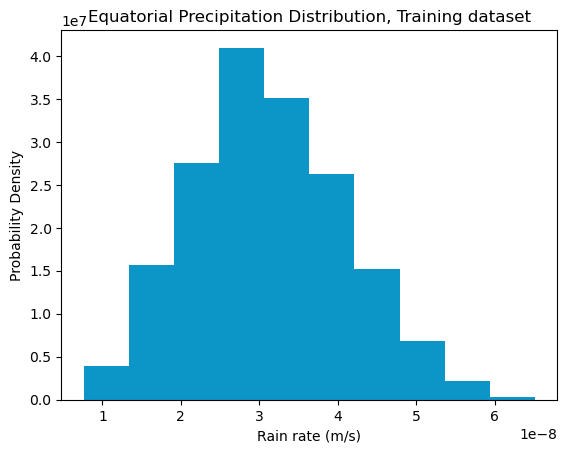

In [115]:
plt.hist(precc, bins=10, color=(12/255, 149/255, 199/255), density=True)
plt.title("Equatorial Precipitation Distribution, Training dataset")
plt.xlabel("Rain rate (m/s)")
plt.ylabel("Probability Density")
#plt.savefig(figure_path + 'precip_data.png')

In [175]:
train.state_t.isel(ncol=5, lev=19).values

array([0.82226869, 0.79339542, 0.80879752, ..., 0.88340465, 0.85818708,
       0.84046194])

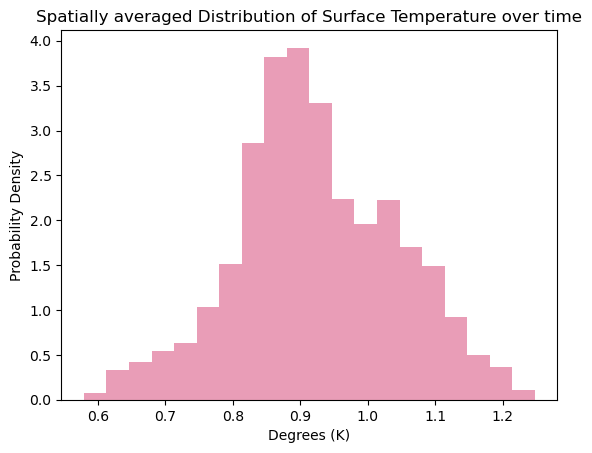

In [176]:
plt.hist(train.state_t.isel(ncol=5, lev=19).values, bins=20, color=(201/255, 12/255, 76/255), alpha=0.4, density=True)[2]
plt.title("Spatially averaged Distribution of Surface Temperature over time")
plt.xlabel("Degrees (K)")
plt.ylabel("Probability Density")
plt.savefig(figure_path + "temp_dist.png")

## ReTraining Model (as necessary)

In [50]:
import sys

In [51]:
model_params = {'beta': 0.05,
 'data_dims': 44,
 'label_dims': 43,
 'latent_dims': 6,
 'input_layers': [32, 16],
 'output_layers': [16, 32],
 'dropout': 0.0,
 'device': 'cuda',
 'architecture': 'ved'}

In [52]:
model = VariationalEncoderDecoder(model_params)
model

VariationalEncoderDecoder(
  (encoder): VariationalEncoder(
    (linear0): Sequential(
      (0): Linear(in_features=44, out_features=32, bias=True)
      (1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (2): Dropout(p=0.0, inplace=False)
    )
    (linear1): Sequential(
      (0): Linear(in_features=32, out_features=16, bias=True)
      (1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (2): Dropout(p=0.0, inplace=False)
    )
    (linear_mean): Linear(in_features=16, out_features=6, bias=True)
    (linear_logstd): Linear(in_features=16, out_features=6, bias=True)
  )
  (decoder): Decoder(
    (linear0): Sequential(
      (0): Linear(in_features=6, out_features=16, bias=True)
      (1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (2): Dropout(p=0.0, inplace=False)
    )
    (linear1): Sequential(
      (0): Linear(in_features=16, out_features=32, bias=True)
      (1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (2): Dropout(p=0

In [55]:
len(train_dataset)

163584

In [521]:
31 / 31 + 1.2


2.2

In [520]:
L_final.pca.explained_variance_

array([0.31097284, 0.01276363])

In [56]:
def get_num_parameters(model, show=False):
    p = iter(model.parameters())
    num = 0
    for param in p:
        ps = 1
        for i in param.shape:
            ps = ps * i
        if show:
            print(param.shape, ps)
        num = num + ps
    return(num)
get_num_parameters(model, False)

8762

In [57]:
len(train_dataset) / get_num_parameters(model, False)

18.66971011184661

In [58]:
model(train_dataset[0][0])

tensor([-0.0833,  0.3862,  0.0633,  0.6447,  0.2164,  0.2366, -0.1743, -0.4941,
        -0.2128,  0.3231,  0.0049,  0.2932,  0.3998, -0.6593, -0.0254,  0.0137,
        -0.5539, -0.7124, -0.1438,  0.3787,  0.2819,  0.0341,  0.2551, -1.2193,
        -0.0955, -0.0543, -0.2420, -0.6682, -0.2735,  0.1153, -0.2849,  0.9690,
        -0.4453, -0.3320,  0.1090, -0.1341,  0.3125,  0.1218,  0.1634, -0.4703,
        -0.6681, -0.0578, -0.4159, -0.4586,  1.0476,  0.2827, -0.0937,  1.0554,
         0.0405, -0.0425, -0.1041,  0.2927,  0.0876,  0.3916, -0.3470, -0.3817,
        -0.8690, -0.1092, -0.1508, -0.4092, -0.9320, -0.3909,  0.0358, -0.4328,
         0.0866, -0.5414,  0.2773, -0.6225,  0.4324,  1.2993, -0.3073,  0.4234,
        -0.4200,  0.7119,  0.1250,  0.5409,  0.4537,  0.8960,  0.5380, -0.3146,
         0.0861, -0.5397,  0.3894, -0.3542, -0.0465,  0.2914, -0.0613],
       device='cuda:0', grad_fn=<AddBackward0>)

In [59]:
model_params

{'beta': 0.05,
 'data_dims': 44,
 'label_dims': 43,
 'latent_dims': 6,
 'input_layers': [32, 16],
 'output_layers': [16, 32],
 'dropout': 0.0,
 'device': 'cuda',
 'architecture': 'ved'}

In [61]:
train_params = {'epochs': 20,
 'loss_type': 'mse',
 'optimizer': 'adam',
 'lr': 0.005,
 'weight_decay': 0,
 'batch_size': 64,
}

In [62]:
save_params = {
    'name' : 'VED_final', # RMB
    'plot' : False,
    'save' : True,
    'model_path' : "/home/jovyan/Samarth/Main/saved_data/models", 
    'savefig' : False,
    'save_interval' : 500,
    'figure_path' : '/home/jovyan/Samarth/Main/saved_data/figures',
    'filetype' : '.pt',
}

In [63]:
def sigmoid(x):
    return(1 / (1 + np.exp(-1 *x)))

In [64]:
sigmoid(np.linspace(-5, 1, train_params['epochs']))

array([0.00669285, 0.00915543, 0.01251268, 0.0170798 , 0.02327462,
       0.03164396, 0.04289068, 0.05789566, 0.07772373, 0.10359579,
       0.1368025 , 0.17853337, 0.22960794, 0.29013328, 0.35917484,
       0.43458759, 0.51315486, 0.59107739, 0.66467779, 0.73105858])

In [228]:
models_ld[2].latent_dims

6

In [232]:
def train_model(model, train_xarr, train_params, save_params):
    beta = 0.05
    X_train_xarr, Y_train_xarr = split_input_output(train_xarr)
    X_train_np = X_train_xarr.to_stacked_array("v", sample_dims=["ncol", 'time']).values.reshape(-1, model.data_dims)
    Y_train_np = Y_train_xarr.to_stacked_array("v", sample_dims=["ncol", 'time']).values.reshape(-1, model.label_dims)
    # Training parameters
    if train_params['optimizer'] == 'adam':
        opt = torch.optim.Adam(model.parameters(), lr=train_params['lr'], weight_decay=train_params['weight_decay'])
    elif train_params['optimizer'] == 'sgd':
        opt = torch.optim.SGD(model.parameters(), lr=train_params['lr'], weight_decay=train_params['weight_decay'])
    else:
        raise ValueError('Unknown optimizer')
    opt.zero_grad()
    
    loss_fn = nn.MSELoss()
    
    batches_per_epoch = int(train_xarr.time.size * train_xarr.ncol.size / train_params['batch_size'])
    print(f"{batches_per_epoch} batches per epoch; latent_dims = {model.latent_dims}")
        
    path = os.path.join(save_params['model_path'], save_params['name']) + save_params['filetype'] # checkpoint 
    text = 'Training '
    start = time.time()
    last = start
    last_timed = start

    rec_losses = []
    reg_losses = []
    KL_div = []
    
    for epoch in range(train_params['epochs']):
        np.random.shuffle(X_train_np)
        np.random.shuffle(Y_train_np)
        for batch in range(batches_per_epoch):
            now = time.time()
            x = X_train_np[train_params['batch_size'] * batch: train_params['batch_size'] * (batch + 1), :]
            y = Y_train_np[train_params['batch_size'] * batch: train_params['batch_size'] * (batch + 1), :]
            x = torch.tensor(x, device=device, dtype=torch.float32)
            y = torch.tensor(y, device=device, dtype=torch.float32)
            #O_real = torch.cat([x, y], 1).to(model.device) # actual output desired 

            O_hat = model(x)
            if(O_hat.isnan().any()):
                print("Model produced nan output")
                return(model, x)
            x_hat = O_hat[:, :model.data_dims]
            y_hat = O_hat[:, -model.label_dims:]

            # loss = ((y - y_hat) ** 2).sum() / self.label_dims + self.beta * self.encoder.kl / self.latent_dims
            mse_x = loss_fn(x, x_hat)
            mse_y = loss_fn(y, y_hat)
            loss = mse_x + mse_y + beta * model.encoder.kl
            #loss = (0.5 * (y - y_mean) ** 2 / y_std + torch.log(y_std)).mean() + self.beta * self.encoder.kl
            if(loss.isnan()):
                print(f"IS NAN!!! at batch {batch}, epoch {epoch}")
                return(model, (x, y))
            elif(loss > 100):
                print(f"LOSS IS BIG!!! at batch {batch}, epoch {epoch}")
                print(f"Loss {loss}, mse:{mse_y}, KL:{model.encoder.kl}")
                return(O_hat, O_real)
            #torch.clip(loss, min=-1e5, max=1e5).backward() # backpropagate loss
            if batch == 0 or batch == batches_per_epoch - 1 or now - last > 1.0: # print time status updates
                last = now
                perc = (epoch * batches_per_epoch + batch + 1) / (train_params['epochs'] * batches_per_epoch)
                inv_perc = (train_params['epochs'] * batches_per_epoch) / (epoch * batches_per_epoch + batch + 0.1)
                sys.stdout.write("\r%s[%.1f %%] - %d / %d (%d / %d) - %.1fs [TBD: %.1fs]." %
                                 (text, 100 * perc, epoch + 1, train_params['epochs'], batch + 1, batches_per_epoch,
                                  now - start, (now - start) * (inv_perc - 1)))
                sys.stdout.flush()
            if save_params['save'] and now - last_timed > save_params['save_interval']:
                torch.save(model.state_dict(), path)
                last_timed = now
            
            if(batch % 250 == 0):
                KL_div.append(model.encoder.kl.item())
                rec_losses.append(mse_x.item()) 
                reg_losses.append(mse_y.item()) 
            loss.backward()
            opt.step()
            opt.zero_grad() # VERY IMPORTANT! Reset gradients. 
    KL_div.append(model.encoder.kl.item())
    rec_losses.append(mse_x.item()) 
    reg_losses.append(mse_y.item()) 
    print('\nFinished Training')

    return(model, {"MSE_rec" : rec_losses, "KL" : KL_div, "MSE_reg" : reg_losses})

In [68]:
#VED = VariationalEncoderDecoder(model_params)
#VED

In [69]:
model, info = train_model(model, train, train_params, save_params)

2556 batches per epoch; beta = 0.0066928509242848554
Training [100.0 %] - 20 / 20 (2556 / 2556) - 259.2s [TBD: 0.0s]..
Finished Training


In [184]:
model_params

{'beta': 0.05,
 'data_dims': 44,
 'label_dims': 43,
 'latent_dims': 6,
 'input_layers': [32, 16],
 'output_layers': [16, 32],
 'dropout': 0.0,
 'device': 'cuda',
 'architecture': 'ved'}

In [235]:
train_params_2['epochs'] = 10

In [236]:
%%time
latent_dims = [32, 16, 12, 10, 8, 6, 4, 2]
models_ld = []
for ld in latent_dims:
    model_params['latent_dims'] = ld
    VED = VariationalEncoderDecoder(model_params)
    new_mod, info = train_model(VED, train, train_params_2, save_params_2)
    print(new_mod.latent_dims)
    models_ld.append(new_mod)

2556 batches per epoch; latent_dims = 32
Training [100.0 %] - 10 / 10 (2556 / 2556) - 126.2s [TBD: 0.0s].
Finished Training
32
2556 batches per epoch; latent_dims = 16
Training [100.0 %] - 10 / 10 (2556 / 2556) - 125.8s [TBD: 0.0s].
Finished Training
16
2556 batches per epoch; latent_dims = 12
Training [100.0 %] - 10 / 10 (2556 / 2556) - 130.0s [TBD: 0.0s].
Finished Training
12
2556 batches per epoch; latent_dims = 10
Training [100.0 %] - 10 / 10 (2556 / 2556) - 136.0s [TBD: 0.0s].
Finished Training
10
2556 batches per epoch; latent_dims = 8
Training [100.0 %] - 10 / 10 (2556 / 2556) - 133.2s [TBD: 0.0s].
Finished Training
8
2556 batches per epoch; latent_dims = 6
Training [100.0 %] - 10 / 10 (2556 / 2556) - 134.5s [TBD: 0.0s].
Finished Training
6
2556 batches per epoch; latent_dims = 4
Training [100.0 %] - 10 / 10 (2556 / 2556) - 136.3s [TBD: 0.0s].
Finished Training
4
2556 batches per epoch; latent_dims = 2
Training [100.0 %] - 10 / 10 (2556 / 2556) - 134.0s [TBD: 0.0s].
Finished Tra

In [103]:
save_params

{'name': 'VED_final',
 'plot': False,
 'save': True,
 'model_path': '/home/jovyan/Samarth/Main/saved_data/models',
 'savefig': False,
 'save_interval': 500,
 'figure_path': '/home/jovyan/Samarth/Main/saved_data/figures',
 'filetype': '.pt'}

In [237]:
#plt.plot(np.arange(len(info['MSE_rec'])) * 250 / 2556, info['MSE_rec'], color=(180/255, 24/255, 156/255), alpha=0.63)
#plt.title('Training Reconstruction Loss every 250 batches')
#plt.xlabel("Epochs")
#plt.ylabel("MSE")           
#plt.savefig(save_params['figure_path'] + '/final_rec_loss.png')

In [105]:
info.keys()

dict_keys(['MSE_rec', 'KL', 'MSE_reg'])

In [238]:
#plt.plot(np.arange(len(info['KL'])) * 250 / 2556, info['KL'], color=(212/255, 122/255, 32/255), alpha=0.43)
#plt.title('KL Divergence every 250 batches')
#plt.xlabel("Epochs")
#plt.ylabel("KL")           
#plt.savefig(save_params['figure_path'] + '/final_KL.png')
#plt.show()

In [239]:
#plt.plot(np.arange(len(info['MSE_reg'])) * 250 / 2556, info['MSE_reg'], color=(44/255, 176/255, 152/255), alpha=0.93)
#plt.title('Training Regression Loss every 250 batches')
#plt.xlabel("Epochs")
#plt.ylabel("MSE")           
#plt.savefig(save_params['figure_path'] + '/final_reg_loss.png')
#plt.show()

In [240]:
#plt.plot(info['MSE_rec'])

In [73]:
model.encoder.kl

tensor(0.4424, device='cuda:0', grad_fn=<MeanBackward0>)

In [74]:
def has_nan_weight(model):
    g = iter(model.parameters())
    for layer in g:
        if(layer.isnan().any()):
            return(True)
    return(False)

# Validating Model

In [234]:
#model, params = load_model('beta_annealed_PC_dir')

In [130]:
name = 'VED_final'

In [ ]:
load_model(name)

In [116]:
model.eval()

VariationalEncoderDecoder(
  (encoder): VariationalEncoder(
    (linear0): Sequential(
      (0): Linear(in_features=44, out_features=32, bias=True)
      (1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (2): Dropout(p=0.0, inplace=False)
    )
    (linear1): Sequential(
      (0): Linear(in_features=32, out_features=16, bias=True)
      (1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (2): Dropout(p=0.0, inplace=False)
    )
    (linear_mean): Linear(in_features=16, out_features=6, bias=True)
    (linear_logstd): Linear(in_features=16, out_features=6, bias=True)
  )
  (decoder): Decoder(
    (linear0): Sequential(
      (0): Linear(in_features=6, out_features=16, bias=True)
      (1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (2): Dropout(p=0.0, inplace=False)
    )
    (linear1): Sequential(
      (0): Linear(in_features=16, out_features=32, bias=True)
      (1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (2): Dropout(p=0

In [79]:
print(model.training)
next(model.parameters())

False


Parameter containing:
tensor([[ 0.3962, -0.9828,  0.7617,  ...,  0.5146,  0.6467,  1.0577],
        [-0.0081,  0.2081, -0.0800,  ...,  1.1401, -1.1342,  0.9870],
        [-0.3000,  0.1073, -0.7565,  ..., -0.1943,  0.9295, -1.0224],
        ...,
        [-0.8333,  0.1169,  0.5420,  ..., -0.3056,  0.4077, -0.0867],
        [-2.3123,  0.3596,  1.8747,  ...,  2.2517, -2.4438,  1.2872],
        [ 0.9306, -1.1787, -2.1855,  ...,  0.3691,  0.3002,  0.6737]],
       device='cuda:0', requires_grad=True)

In [80]:
x, y = test_dataset[0]
model(x).shape

torch.Size([87])

In [235]:
#model, params = load_model('beta_annealed_PC_dir')

## Quantitative Eval

In [81]:
import sklearn
from sklearn.metrics import r2_score
import scipy

In [82]:
X_test_np.shape

(23296, 44)

In [83]:
Y_test_np.shape

(23296, 43)

In [189]:
x, y = test_dataset[0]

In [201]:
model(x)[:model.data_dims].cpu().detach().numpy()

array([-0.14483288,  0.03110029,  0.3224595 , -0.6587164 , -0.48711765,
        1.127538  ,  1.3290398 ,  1.4028401 ,  1.370713  ,  1.3024427 ,
        1.13453   ,  1.0620015 ,  1.0456095 ,  1.0762006 ,  1.1474179 ,
        1.2115088 ,  1.2447932 ,  1.2284193 ,  1.193089  ,  1.1986392 ,
        0.07884279,  0.27739272, -0.03237071, -1.0903343 , -1.0347909 ,
        0.7998807 ,  0.95247483,  0.97917414,  0.9626506 ,  0.9430654 ,
        0.91245687,  0.9082428 ,  0.91277456,  0.90740013,  0.8696049 ,
        0.8307238 ,  0.8023023 ,  0.7950603 ,  0.7833694 ,  0.77315956,
        0.6028722 ,  0.56669885, -0.0505065 ,  0.19007301], dtype=float32)

In [359]:
model

VariationalEncoderDecoder(
  (encoder): VariationalEncoder(
    (linear0): Sequential(
      (0): Linear(in_features=44, out_features=32, bias=True)
      (1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (2): Dropout(p=0.0, inplace=False)
    )
    (linear1): Sequential(
      (0): Linear(in_features=32, out_features=16, bias=True)
      (1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (2): Dropout(p=0.0, inplace=False)
    )
    (linear_mean): Linear(in_features=16, out_features=6, bias=True)
    (linear_logstd): Linear(in_features=16, out_features=6, bias=True)
  )
  (decoder): Decoder(
    (linear0): Sequential(
      (0): Linear(in_features=6, out_features=16, bias=True)
      (1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (2): Dropout(p=0.0, inplace=False)
    )
    (linear1): Sequential(
      (0): Linear(in_features=16, out_features=32, bias=True)
      (1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (2): Dropout(p=0

In [361]:
model_params

{'beta': 0.05,
 'data_dims': 44,
 'label_dims': 43,
 'latent_dims': 2,
 'input_layers': [32, 16],
 'output_layers': [16, 32],
 'dropout': 0.0,
 'device': 'cuda',
 'architecture': 'ved'}

In [84]:
loss_fn = torch.nn.MSELoss()

In [85]:
Y_test_np.shape

(23296, 43)

In [90]:
Y_test_np.shape

(23296, 43)

In [86]:
O_hat = model(torch.tensor(X_test_np, dtype=torch.float32, device=device))

In [87]:
x_hat, y_hat = O_hat[:, :model.data_dims], O_hat[:, -model.label_dims:]

In [88]:
y_hat.shape

torch.Size([23296, 43])

In [92]:
loss_fn(y_hat, torch.tensor(Y_test_np, dtype=torch.float32, device=device))

tensor(0.4031, device='cuda:0', grad_fn=<MseLossBackward0>)

### Exploring Latent Dimensionality

In [241]:
latent_dims

[32, 16, 12, 10, 8, 6, 4, 2]

In [244]:
print(len(models_ld))
models_ld[3].latent_dims

8


10

In [318]:
X_test_xarr, Y_test_xarr = split_input_output(test)

X_test_np = X_test_xarr.to_stacked_array("v", sample_dims=["ncol", 'time']).values.reshape(-1, 44)
Y_test_np = Y_test_xarr.to_stacked_array("v", sample_dims=["ncol", 'time']).values.reshape(-1, 43)

In [320]:
x_test = torch.tensor(X_test_np)
y_test = torch.tensor(Y_test_np)

In [299]:
x_test.shape

torch.Size([23296, 44])

In [321]:
combined = torch.cat([x_test, y_test], 1).numpy()
np.random.shuffle(combined)
combined.shape

(23296, 87)

In [329]:
combined[0, 0:43] - combined[0, 44:]

array([ 0.00000000e+00,  0.00000000e+00,  7.77141644e-05, -3.39288626e-03,
       -1.49438751e-03, -4.18159780e-03, -1.52269539e-02, -3.28187062e-03,
       -1.07332806e-02, -9.70067269e-03, -1.23366065e-03, -6.14702023e-05,
        2.10719363e-04, -8.07674255e-04, -1.57870514e-03, -7.80403528e-03,
       -3.34615877e-03, -7.90893210e-03,  9.60557862e-04, -4.23723096e-04,
       -3.81293526e-03,  1.23729773e-03, -2.10254337e-03, -2.51870194e-04,
        1.19628483e-04,  1.39770405e-03,  1.63431164e-03,  1.70140542e-03,
        2.88692528e-03,  2.45150040e-03,  1.53508647e-03,  1.24855487e-03,
        1.68660146e-03,  1.84886073e-03,  2.85221325e-03,  3.00462846e-03,
        1.27122285e-03,  6.23075745e-04, -1.43630651e-03, -2.39629094e-03,
       -5.55837094e-01, -4.45392564e-01, -2.51556222e-01])

In [330]:
x_test, y_test = combined[:, :44], combined[:, 44:]

In [334]:
x_test[0, :-1] - y_test[0, :]

array([ 0.00000000e+00,  0.00000000e+00,  7.77141644e-05, -3.39288626e-03,
       -1.49438751e-03, -4.18159780e-03, -1.52269539e-02, -3.28187062e-03,
       -1.07332806e-02, -9.70067269e-03, -1.23366065e-03, -6.14702023e-05,
        2.10719363e-04, -8.07674255e-04, -1.57870514e-03, -7.80403528e-03,
       -3.34615877e-03, -7.90893210e-03,  9.60557862e-04, -4.23723096e-04,
       -3.81293526e-03,  1.23729773e-03, -2.10254337e-03, -2.51870194e-04,
        1.19628483e-04,  1.39770405e-03,  1.63431164e-03,  1.70140542e-03,
        2.88692528e-03,  2.45150040e-03,  1.53508647e-03,  1.24855487e-03,
        1.68660146e-03,  1.84886073e-03,  2.85221325e-03,  3.00462846e-03,
        1.27122285e-03,  6.23075745e-04, -1.43630651e-03, -2.39629094e-03,
       -5.55837094e-01, -4.45392564e-01, -2.51556222e-01])

In [335]:
x_test = torch.tensor(x_test, dtype=torch.float32, device=device)
y_test = torch.tensor(y_test, dtype=torch.float32, device=device)

In [336]:
x_test.shape

torch.Size([23296, 44])

In [338]:
errors = []

In [510]:
len(train_dataset)

163584

In [339]:
for VED in models_ld:
    print(VED.latent_dims)
    O_hat = VED(x_test)
    x_hat, y_hat = O_hat[:, :model.data_dims], O_hat[:, -model.label_dims:]
    
    mse = loss_fn(y_hat, y_test).item()
    errors.append(mse)

32
16
12
10
8
6
4
2


In [340]:
errors

[0.3926951587200165,
 0.40161821246147156,
 0.39875346422195435,
 0.40214329957962036,
 0.40212777256965637,
 0.3990117907524109,
 0.3947782516479492,
 0.3992225229740143]

In [347]:
save_params['figure_path']

'/home/jovyan/Samarth/Main/saved_data/figures'

In [349]:
import seaborn as sns

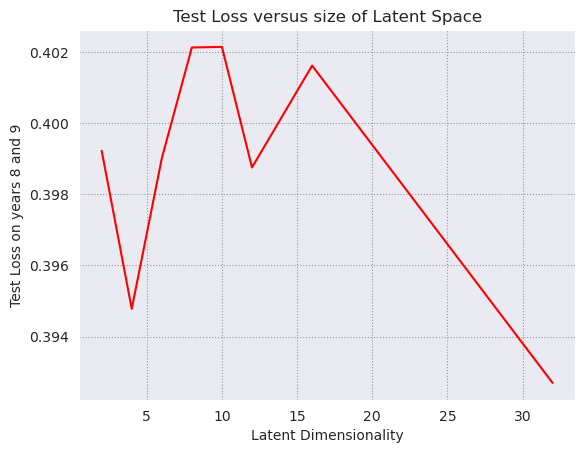

In [358]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.lineplot(x=latent_dims, y=errors, color='red')
plt.title("Test Loss versus size of Latent Space")
plt.xlabel("Latent Dimensionality")
plt.ylabel("Test Loss on years 8 and 9")
plt.savefig(save_params['figure_path'] + '/latent_dims_mse.png')

In [345]:
test

<xarray.Dataset>
Dimensions:            (time: 364, ncol: 64, lev: 20)
Coordinates:
  * time               (time) object 0008-02-02 12:00:00 ... 0009-01-31 12:00:00
  * ncol               (ncol) int64 18 19 22 23 26 27 ... 229 232 233 236 237
    lat                (ncol) float64 -4.43 -5.01 -5.41 -5.61 ... 5.41 5.01 4.43
    lon                (ncol) float64 -39.4 -28.15 -16.89 ... -61.85 -50.6
Dimensions without coordinates: lev
Data variables:
    state_q0001        (time, lev, ncol) float64 0.9061 0.9048 ... 0.7871 0.7784
    state_t            (time, lev, ncol) float64 0.8554 0.6009 ... 0.9674 0.8621
    pbuf_SOLIN         (time, ncol) float64 0.7599 0.773 ... 0.4913 0.5096
    pbuf_LHFLX         (time, ncol) float64 0.4588 0.3838 ... -0.7954 0.2793
    pbuf_SHFLX         (time, ncol) float64 -0.4393 -0.1566 ... 1.963 0.3117
    state_ps           (time, ncol) float64 0.1988 0.4806 ... 0.03356 0.3592
    out_state_q0001    (time, lev, ncol) float64 0.9061 0.9048 ... 0.7908 0.7777
    out_state_t        (time, lev, ncol) float64 0.8551 0.6017 ... 0.9694 0.8649
    out_cam_out_NETSW  (time, ncol) float64 -0.3796 -0.4592 ... -0.09355 0.1072
    out_cam_out_FLWDS  (time, ncol) float64 1.13 1.111 0.8737 ... 1.178 1.17
    out_cam_out_PRECC  (time, ncol) float64 -0.4137 2.544 ... -0.4148 -0.4159

### MOAD

In [117]:
def assess_model(model, x_test, y_test):
    n_samples = y_test.shape[0]
    O_hat = model(torch.tensor(x_test, dtype=torch.float32, device=device))
    x_hat, y_hat = O_hat[:, :model.data_dims], O_hat[:, -model.label_dims:].cpu().detach().numpy()
    print(y_hat.shape)
    print(y_test.shape)
    
    loss_fn = torch.nn.MSELoss()
    mse = loss_fn(torch.tensor(y_hat), torch.tensor(y_test)).item()
    
    pearson = []
    p_value = []
    
    R_squared = []
    
    for i in range(n_samples):
        p = scipy.stats.pearsonr(y_hat[i, :], y_test[i, :])
        pearson.append(p.statistic)
        p_value.append(p.pvalue)
        
        R_squared.append(r2_score(y_hat[i, :], y_test[i,:]))
    
    r2 = np.array(R_squared).mean()
    pear = np.array(pearson).mean()
    p_val = np.array(p_value).mean()
    
    metrics = {'mse' : mse, 'r2':r2, 'pearson':pear, 'p_val':p_val}
    
            
    return(metrics)

In [122]:
np.unique(train.lat.values)

array([-5.61, -5.41, -5.01, -4.43,  4.43,  5.01,  5.41,  5.61])

In [118]:
assess_model(model, X_test_np, Y_test_np)

(23296, 43)
(23296, 43)


{'mse': 0.40305621104011735,
 'r2': -0.3717115347614295,
 'pearson': 0.6748220141571751,
 'p_val': 0.005898195749686695}

In [227]:
assess_model(model, X_test_np, Y_test_np)

(5824, 43)
(5824, 43)


{'mse': 0.3787509269774352,
 'r2': -0.25193030903351543,
 'pearson': 0.6757026026927296,
 'p_val': 0.007641102317631677}

## Plotting Features against Principal Components

In [366]:
train_dataset

In [363]:
model, params = load_model("beta_annealed_PC_dir")

In [368]:
%%time
L_beta = LatentInterpreter(model, train_dataset)
L_beta.calculate_embeddings(500)

CPU times: user 20.1 s, sys: 90.8 ms, total: 20.2 s
Wall time: 20.2 s


thresholding at 301.2190030048595


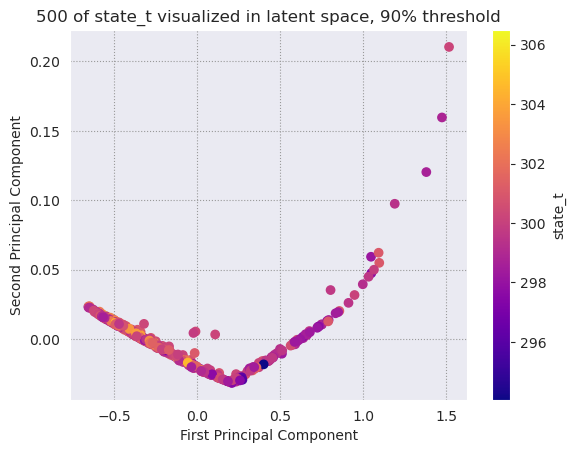

In [370]:
L_beta.latentPCA()
x,y,c=L_beta.plot_variable_PC('state_t', binarize=False)

In [374]:
#L_beta.estimate_pz([0,1,2,3,4,5], 10)

In [405]:
final_model, params = load_model("VED_final")

In [406]:
%%time
L_final = LatentInterpreter(final_model, train_dataset)
L_final.set_embeddings(fin_embeddings)
L_final.latentPCA()
x,y,c=L_final.plot_variable_PC('state_t', binarize=True, percentile=90, title='Binarized Latent Embeddings, Surface Temperature', save=False)


CPU times: user 41.9 s, sys: 184 ms, total: 42.1 s
Wall time: 42.1 s


In [447]:
fin_embeddings = L_final.embeddings

thresholding at 301.2190030048595


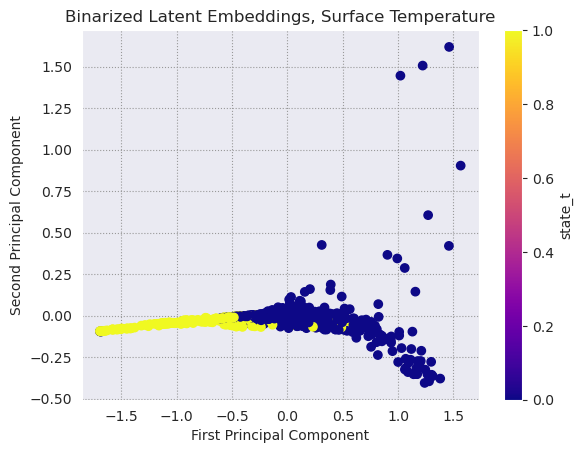

In [408]:
L_final.latentPCA()
x,y,c=L_final.plot_variable_PC('state_t', binarize=True, percentile=90, title='Binarized Latent Embeddings, Surface Temperature', save=True)

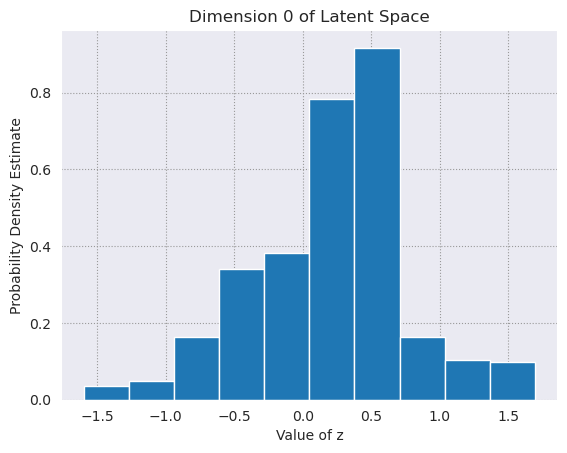

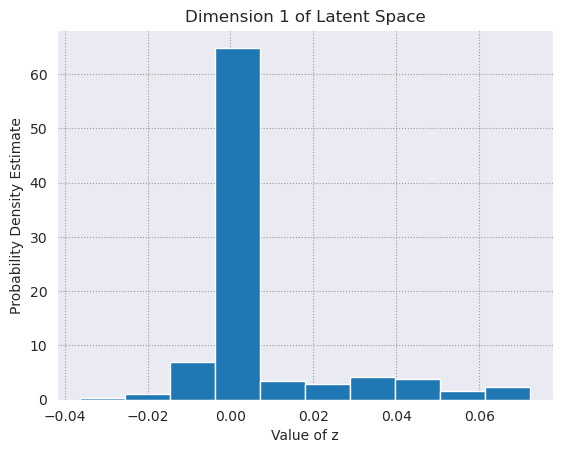

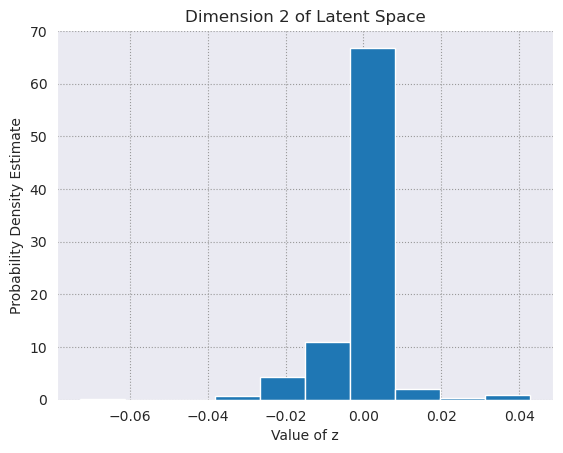

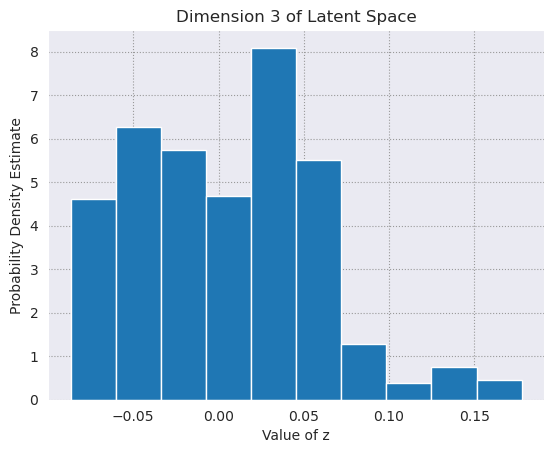

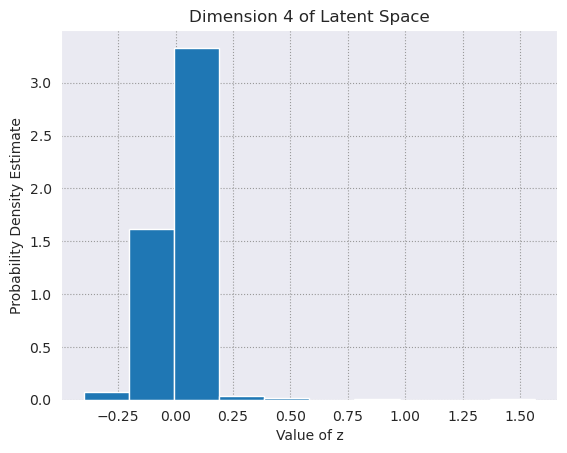

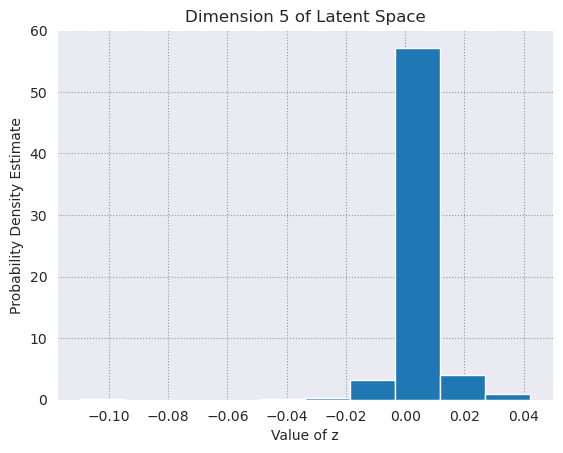

In [387]:
L_final.estimate_pz([0,1,2,3,4,5], 10)

In [392]:
model, params = load_model("VED_trial3_npy")


In [393]:
%%time
L_trial = LatentInterpreter(model, train_dataset)
L_trial.calculate_embeddings(1000)

CPU times: user 44.2 s, sys: 220 ms, total: 44.4 s
Wall time: 44.4 s


thresholding at 301.2190030048595


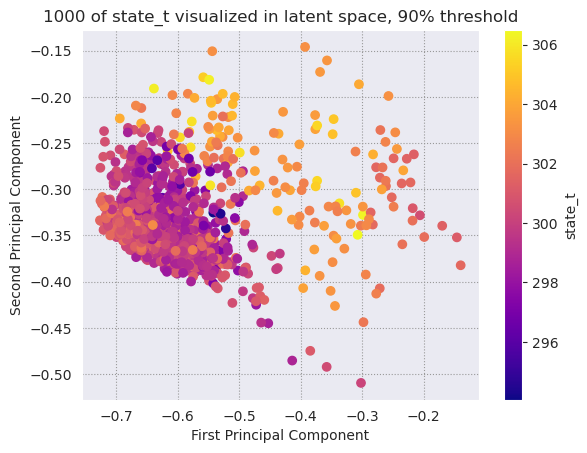

In [394]:
L_trial.latentPCA()
x,y,c=L_trial.plot_variable_PC('state_t', binarize=False)

In [401]:
#L_trial.estimate_pz([0,1,2,3,4,5], 10)

In [131]:
import scipy
import sklearn
from sklearn.decomposition import PCA

In [132]:
def save_model(model):
    path = os.path.join(save_params['model_path'], save_params['name'])
    torch.save(model.state_dict(), path + save_params['filetype'])
    
    params = {
        'training_parameters' : train_params, 
        'model_parameters' : model_params, 
        'save_parameters' : save_params,
        'info' : info,
    }
    
    with open(path + ".json", 'w', encoding='utf-8') as f:
        json.dump(params, f, ensure_ascii=False, indent=4) 
    return(path)

In [125]:
save_params['name'] = "VED_final"

In [129]:
save_model(model)

'/home/jovyan/Samarth/Main/saved_data/models/VED_final'

In [465]:
class LatentInterpreter():
    def __init__(self, model, dataset):
        model.eval()
        self.model = model
        self.dataset = dataset
        self.embeddings = {}
        self.latent_dims = model.latent_dims
        self.pca = 0

    def calculate_embeddings(self, num_samples=500, start_index=0):
        self.embeddings = {}
        with torch.no_grad():
            for i in range(start_index, start_index + num_samples):
                x, y = self.dataset[i]
                z = self.model(x, return_latent=True).to('cpu').numpy()
                self.embeddings[i] = z
        self.pca = 0
                
    def decode_embeddings(self):
        self.generations = {}
        with torch.no_grad():
            for i, z in self.embeddings.items():
                z = torch.tensor(z, device=device, dtype=torch.float32)
                self.generations[i] = self.decode_latent(z)

    def decode_latent(self, z):
        if(type(z) == np.ndarray):
            z = torch.tensor(z, dtype=torch.float32, device=device)
        Omu = model.decoder(z)
        norm = Omu.detach().cpu().numpy() * ds_sigma + ds_mu
        return(norm[:44], norm[-43:])
    
    def embeddings_as_tensor(self):
        return(torch.tensor(np.vstack(list(self.embeddings.values())), dtype=torch.float32))
                
    def set_embeddings(self, embeddings):
        assert type(embeddings) == dict, "Expected a dictionary format"
        self.embeddings = embeddings
    
    def latentPCA(self):
        if(not len(self.embeddings)): # if have not saved embeddings
            print("Recalculating Embeddings")
            self.calculate_embeddings()
        
        pca = PCA(n_components=2)
        pca.fit(list(self.embeddings.values()))
        self.pca = pca
    
    def plot_variable_PC(self, variable, lev=59, binarize=True, percentile = 90, cmap='plasma', title='', save=False):
        # assume data to be segmented in some form to highlight/ visualize some specific trend
        # components is ndarray shape (n_components, n_features)
        if(not self.pca):
            self.latentPCA()
        if not title:
            title=f'{len(self.embeddings)} of {variable} visualized in latent space, {percentile}% threshold'
        pc1 = torch.tensor(self.pca.components_[0, :], dtype=torch.float32)
        pc2 = torch.tensor(self.pca.components_[1, :], dtype=torch.float32)
        
        z = self.embeddings_as_tensor()
        x_values = torch.matmul(z, pc1)
        y_values = torch.matmul(z, pc2)
        c_values = get_item_values(self.dataset.ds, list(self.embeddings.keys()), variable, lev), 
        var_vals = ds.sel(lev=selected_levels.index(lev))[variable].values.flatten()
        threshold_value = scipy.stats.scoreatpercentile(var_vals, percentile)
        print(f"thresholding at {threshold_value}")
        if(binarize):
            c_values_bin = (c_values > threshold_value).astype(int)
            plt.scatter(x_values, y_values, c=c_values_bin, cmap=cmap)
        else:
            plt.scatter(x_values, y_values, c=c_values, cmap=cmap)
        plt.colorbar(label=variable)
        plt.xlabel("First Principal Component")
        plt.ylabel("Second Principal Component")
        plt.title(title)
        if(save):
            plt.savefig("latent_viz.png")
        #plt.show()
        return(x_values.numpy(), y_values.numpy(), c_values)
    
    def estimate_pz(self, dims, bins):
        z = self.embeddings_as_tensor()
        for dim in dims:
            plt.hist(z[:, dim], bins=bins, density=True)
            plt.title(f"Dimension {dim} of Latent Space")
            plt.xlabel("Value of z")
            plt.ylabel("Probability Density Estimate")
            plt.show()

In [152]:
train_dataset[0]

(tensor([-1.3674, -2.4509, -2.7442, -1.3964, -0.6886,  1.2418,  1.5715,  1.6876,
          1.7375,  1.6725,  1.2917,  1.2847,  1.4900,  1.4019,  1.3129,  1.2523,
          1.2933,  1.3462,  1.3221,  1.3280,  0.6809,  0.1051,  0.2503, -1.2607,
         -1.6586,  0.6136,  0.8539,  0.8807,  0.8320,  0.7781,  0.7820,  0.8725,
          0.9029,  0.8903,  0.8367,  0.8116,  0.7813,  0.7691,  0.7698,  0.7763,
          0.7580,  0.4344, -0.4445,  0.1975], device='cuda:0'),
 tensor([-1.3674, -2.4509, -2.7438, -1.3928, -0.6673,  1.1531,  1.5219,  1.6804,
          1.7535,  1.7101,  1.3172,  1.2970,  1.4959,  1.4074,  1.3185,  1.2582,
          1.2964,  1.3475,  1.3307,  1.3277,  0.6818,  0.1067,  0.2498, -1.2608,
         -1.6578,  0.6108,  0.8573,  0.8863,  0.8364,  0.7764,  0.7756,  0.8688,
          0.9006,  0.8876,  0.8346,  0.8099,  0.7807,  0.7683,  0.7691,  0.7789,
         -0.1740,  1.1056, -0.4092], device='cuda:0'))

In [157]:
train_dataset[5][0][39] * ds_sigma[39] + ds_mu[39]

tensor(305.1795, device='cuda:0')

In [174]:
a=ds.sel(lev=19)['state_t'].values.flatten()
scipy.stats.scoreatpercentile(a, 90)

301.2190030048595

In [173]:
ds.sel(lev=19)['state_t'].mean()#.values.flatten()

<xarray.DataArray 'state_t' ()>
array(288.44034184)

In [154]:
cval = get_item_values(L.dataset.ds, list(L.embeddings.keys()), 'state_t', 59)
cval[167]

299.14186871675224

In [137]:
L = LatentInterpreter(model, train_dataset)

In [138]:
%%time
L.calculate_embeddings(1000)
embeddings = L.embeddings

CPU times: user 43.8 s, sys: 224 ms, total: 44 s
Wall time: 44 s


In [141]:
L.set_embeddings(embeddings)
L.latentPCA()

In [142]:
ds.data_vars

Data variables:
    state_q0001        (time, lev, ncol) float64 1.424e-06 ... 0.003413
    state_t            (time, lev, ncol) float64 257.8 258.9 ... 265.4 275.4
    pbuf_SOLIN         (time, ncol) float64 477.9 475.6 476.4 ... 163.8 198.4
    pbuf_LHFLX         (time, ncol) float64 77.19 113.1 184.8 ... 96.89 28.51
    pbuf_SHFLX         (time, ncol) float64 3.864 9.653 51.89 ... 123.3 12.17
    state_ps           (time, ncol) float64 1.011e+05 1.013e+05 ... 1.006e+05
    out_state_q0001    (time, lev, ncol) float64 1.424e-06 ... 0.003416
    out_state_t        (time, lev, ncol) float64 257.8 258.9 ... 265.2 275.4
    out_cam_out_NETSW  (time, ncol) float64 332.9 313.0 243.3 ... 69.06 79.14
    out_cam_out_FLWDS  (time, ncol) float64 354.8 339.1 399.6 ... 243.8 285.2
    out_cam_out_PRECC  (time, ncol) float64 2.325e-11 1.05e-09 ... 5.284e-09

In [144]:
L.pca.explained_variance_

array([0.31097284, 0.01276363])

In [145]:
L.pca.components_

array([[-0.99913444, -0.01414118,  0.0098133 ,  0.01362728, -0.03489309,
         0.005556  ],
       [-0.03612826, -0.06261856, -0.0608162 , -0.11614035,  0.98622966,
        -0.07026752]])

thresholding at 301.2190030048595


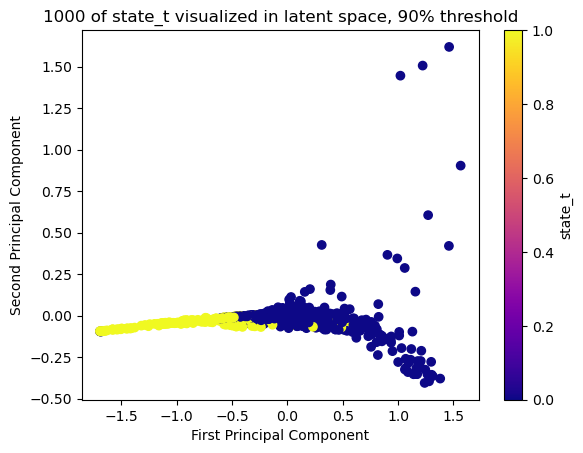

CPU times: user 611 ms, sys: 197 ms, total: 808 ms
Wall time: 574 ms


In [175]:
%%time
title = "Binarized 
x, y, c = L.plot_variable_PC(variable='state_t', lev=59, cmap='plasma', percentile=90, binarize=True, title=)

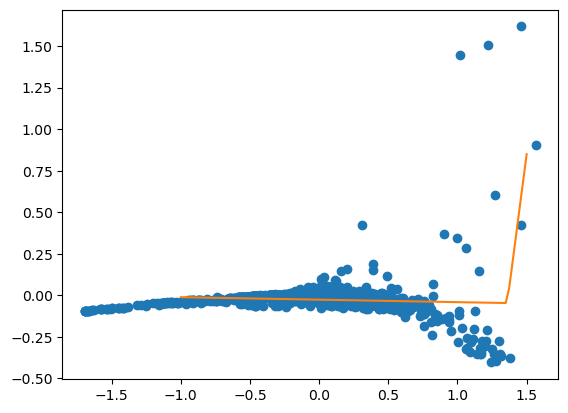

In [177]:
def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

p , e = scipy.optimize.curve_fit(piecewise_linear, x, y)
xd = np.linspace(-1, 1.5, 100)
plt.plot(x, y, "o")
plt.plot(xd, piecewise_linear(xd, *p))

In [314]:
p

array([ 0.23186042, -0.03378584, -0.06099996,  0.10491215])

In [179]:
L.embeddings[5]

array([ 0.85381377,  0.03744839, -0.00813033,  0.09001999,  0.0068285 ,
       -0.00180043], dtype=float32)

In [180]:
L.embeddings_as_tensor()[5, :]

tensor([ 0.8538,  0.0374, -0.0081,  0.0900,  0.0068, -0.0018])

In [378]:
L.decode_embeddings()

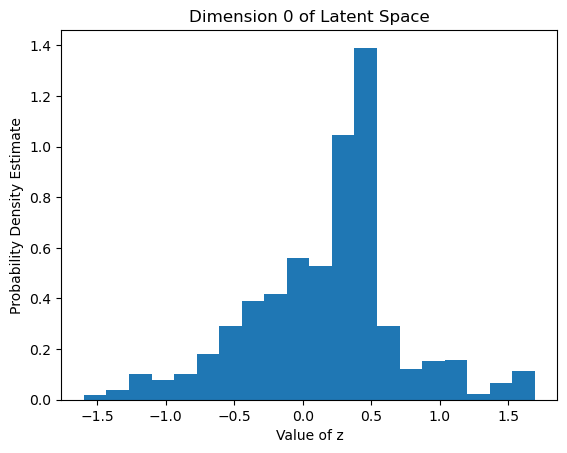

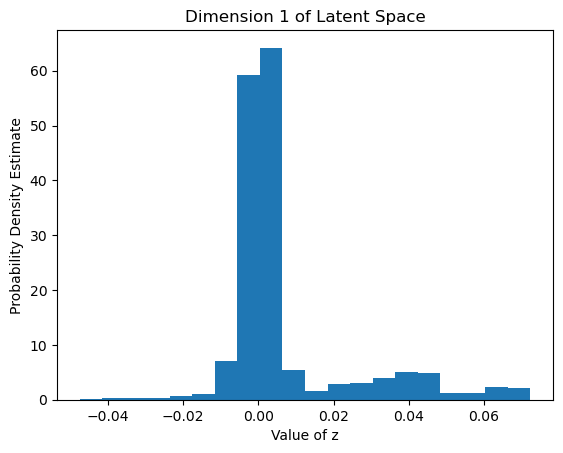

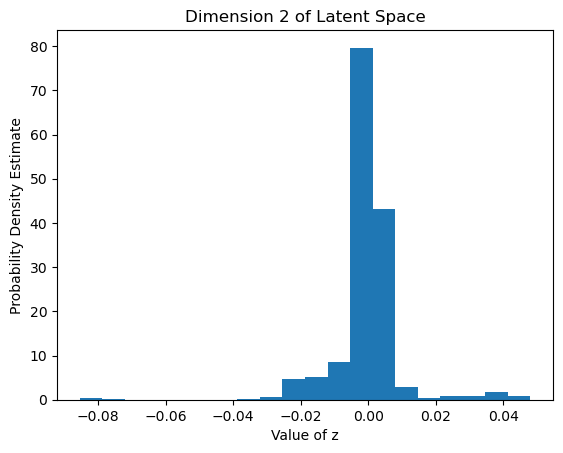

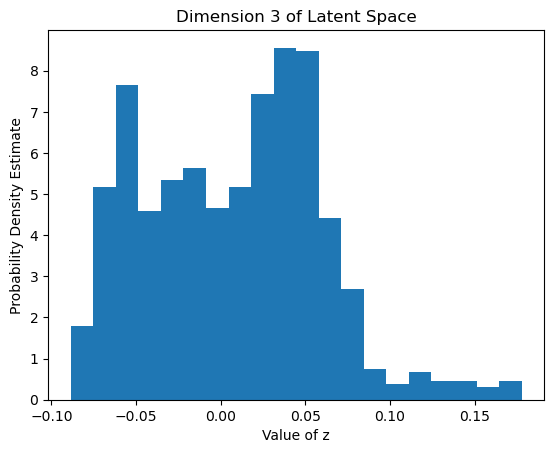

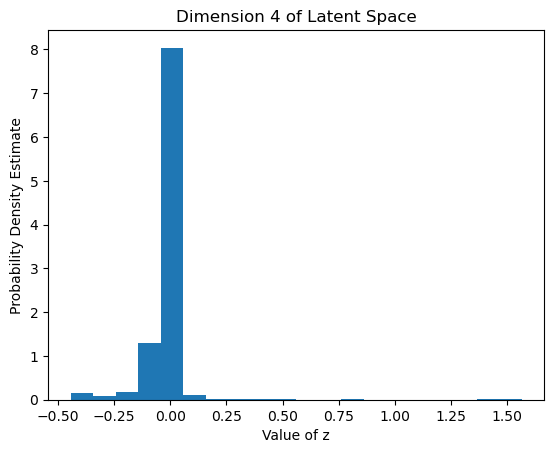

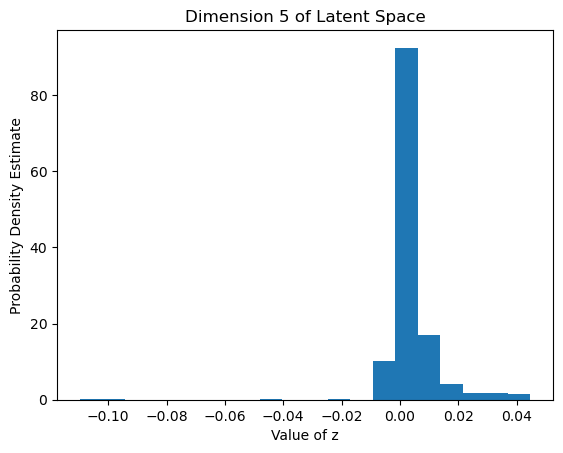

In [181]:
L.estimate_pz([0, 1, 2, 3, 4, 5], 20)

In [26]:
%%time
withmodels_ld.no_grad():
    dataloader = DataLoader(dataset, batch_size=1000, shuffle=False) # not faster
    X, Y = next(iter(dataloader))
    embeddings = model(X, Y, return_latent=True).to('cpu')

CPU times: user 37.7 s, sys: 158 ms, total: 37.8 s
Wall time: 37.8 s


## Latent Traversal

thresholding at 301.2190030048595


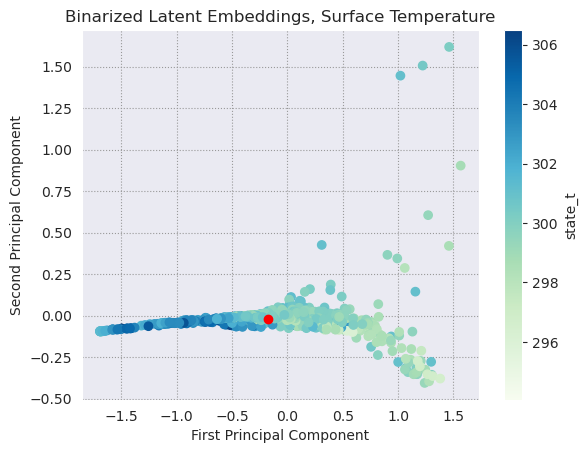

CPU times: user 1.13 s, sys: 663 ms, total: 1.79 s
Wall time: 781 ms


In [471]:
%%time
L_final = LatentInterpreter(final_model, train_dataset)
L_final.set_embeddings(fin_embeddings)
L_final.latentPCA()
x,y,c=L_final.plot_variable_PC('state_t', binarize=False, title='Binarized Latent Embeddings, Surface Temperature', cmap='GnBu')
plt.scatter(np.dot(zmu, pc1), np.dot(zmu, pc2), color='red')
plt.show()


In [450]:
Z = L_final.embeddings_as_tensor().numpy()

In [490]:
L_final.decode_latent(zmus[1])[1][-1]

2.5220377877881842e-08

In [457]:
zmu= Z.mean(axis=0)

In [472]:
zmu

array([ 0.17294581,  0.00679227, -0.00047253,  0.00761771, -0.01347753,
        0.00417047], dtype=float32)

In [460]:
L_final.pca.components_

array([[-0.99913444, -0.01414118,  0.0098133 ,  0.01362728, -0.03489309,
         0.005556  ],
       [-0.03612826, -0.06261856, -0.0608162 , -0.11614035,  0.98622966,
        -0.07026752]])

In [458]:
pc1, pc2 = L_final.pca.components_[0], L_final.pca.components_[1]

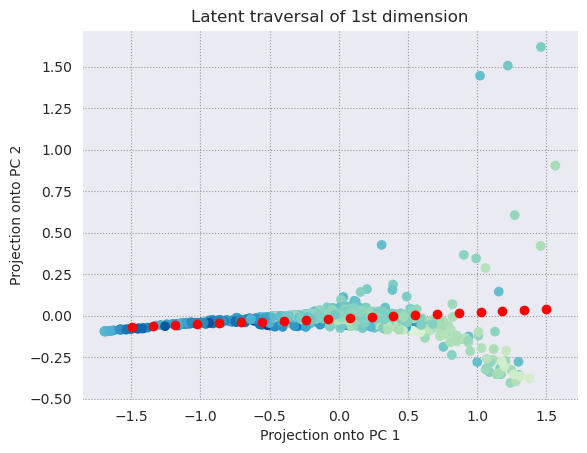

In [486]:
plt.scatter(x, y, c=c, cmap='GnBu')
plt.scatter(zmu_xcoords, zmu_ycoords, color='red')
plt.title("Latent traversal of 1st dimension")
plt.xlabel("Projection onto PC 1")
plt.ylabel("Projection onto PC 2")
plt.savefig(save_params['figure_path'] + '/traversal.png')

In [462]:
np.dot(zmu, pc1), np.dot(zmu, pc2)

(-0.1722995525331966, -0.021114526588703584)

In [473]:
dim_traversal_values = np.linspace(-1.5, 1.5, 20)
dim_traversal_values

array([-1.5       , -1.34210526, -1.18421053, -1.02631579, -0.86842105,
       -0.71052632, -0.55263158, -0.39473684, -0.23684211, -0.07894737,
        0.07894737,  0.23684211,  0.39473684,  0.55263158,  0.71052632,
        0.86842105,  1.02631579,  1.18421053,  1.34210526,  1.5       ])

In [498]:
precips = []
temps = []
for z in zmus:
    x, y = L_final.decode_latent(z)
    precips.append(y[-1])
    temps.append(y[-4])

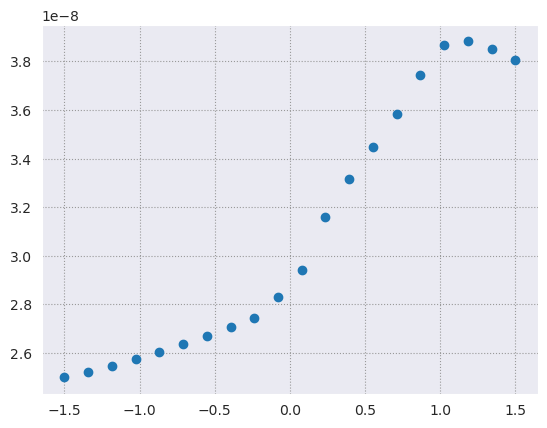

In [503]:
plt.scatter(dim_traversal_values, precips)
plt.show()

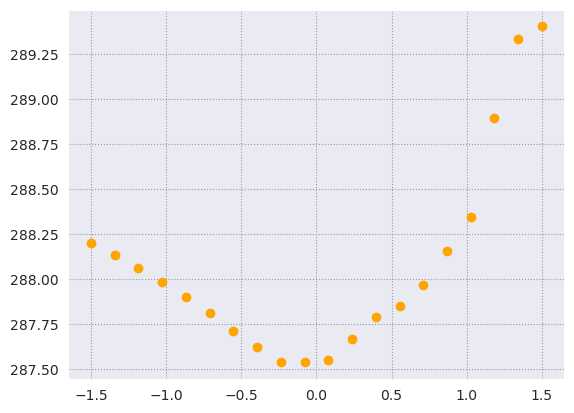

In [504]:
plt.scatter(dim_traversal_values, temps, color='orange')

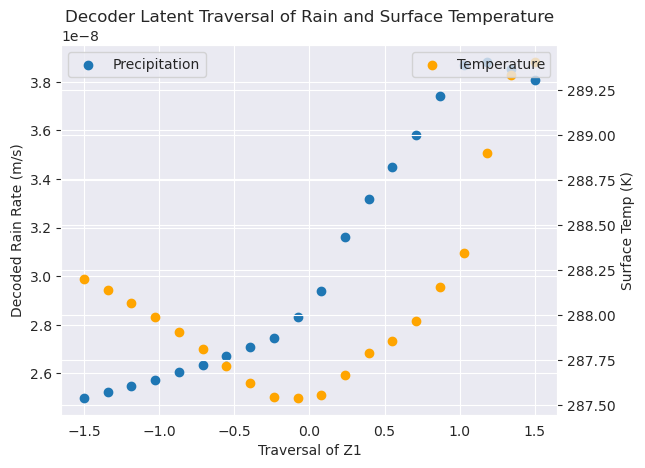

In [509]:
# Create the first scatter plot (left axis)
sns.set_style("darkgrid")

fig, ax1 = plt.subplots()
ax1.scatter(dim_traversal_values, precips, label='Precipitation')
ax1.set_xlabel('Traversal of Z1')
ax1.set_ylabel('Decoded Rain Rate (m/s)')
ax1.set_title('Decoder Latent Traversal of Rain and Surface Temperature')

# Create the second scatter plot (right axis)
ax2 = ax1.twinx()
ax2.scatter(dim_traversal_values, temps, color='orange', label='Temperature')
ax2.set_ylabel('Surface Temp (K)')

# Show the legend for both plots
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.savefig("decoded_traversal.png")

In [479]:
zmus = []
zmu_xcoords = []
zmu_ycoords = []
for i in dim_traversal_values:
    zmu_i = zmu.copy()
    zmu_i[0] = i
    zmus.append(zmu_i)
    zmu_xcoords.append(np.dot(zmu_i, pc1))
    zmu_ycoords.append(np.dot(zmu_i, pc2))

In [481]:
zmu

array([ 0.17294581,  0.00679227, -0.00047253,  0.00761771, -0.01347753,
        0.00417047], dtype=float32)

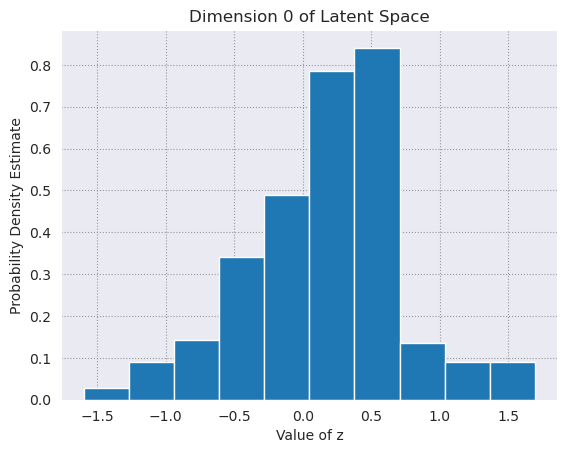

In [467]:
L_final.estimate_pz([0], 10)

In [230]:
model, params = load_model('beta_annealed_PC_dir')

In [185]:
model

VariationalEncoderDecoder(
  (encoder): VariationalEncoder(
    (linear0): Sequential(
      (0): Linear(in_features=44, out_features=32, bias=True)
      (1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (2): Dropout(p=0.0, inplace=False)
    )
    (linear1): Sequential(
      (0): Linear(in_features=32, out_features=16, bias=True)
      (1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (2): Dropout(p=0.0, inplace=False)
    )
    (linear_mean): Linear(in_features=16, out_features=6, bias=True)
    (linear_logstd): Linear(in_features=16, out_features=6, bias=True)
  )
  (decoder): Decoder(
    (linear0): Sequential(
      (0): Linear(in_features=6, out_features=16, bias=True)
      (1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (2): Dropout(p=0.0, inplace=False)
    )
    (linear1): Sequential(
      (0): Linear(in_features=16, out_features=32, bias=True)
      (1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (2): Dropout(p=0

In [433]:
L_traverse = LatentInterpreter(model, train_dataset)
L_traverse.calculate_embeddings(1000)

In [434]:
L_traverse.latentPCA()

thresholding at 301.2190030048595


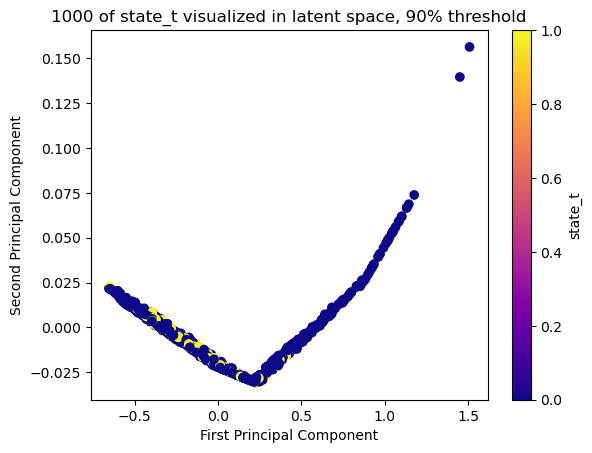

CPU times: user 589 ms, sys: 130 ms, total: 719 ms
Wall time: 485 ms


In [435]:
%%time
x, y, c = L_traverse.plot_variable_PC('state_t', lev=59, cmap='plasma', percentile=90, binarize=True)

In [394]:
# Pick output variable of interest
ds.data_vars

Data variables:
    state_q0001        (time, lev, ncol) float64 1.424e-06 ... 0.003413
    state_t            (time, lev, ncol) float64 257.8 258.9 ... 265.4 275.4
    pbuf_SOLIN         (time, ncol) float64 477.9 475.6 476.4 ... 163.8 198.4
    pbuf_LHFLX         (time, ncol) float64 77.19 113.1 184.8 ... 96.89 28.51
    pbuf_SHFLX         (time, ncol) float64 3.864 9.653 51.89 ... 123.3 12.17
    state_ps           (time, ncol) float64 1.011e+05 1.013e+05 ... 1.006e+05
    out_state_q0001    (time, lev, ncol) float64 1.424e-06 ... 0.003416
    out_state_t        (time, lev, ncol) float64 257.8 258.9 ... 265.2 275.4
    out_cam_out_NETSW  (time, ncol) float64 332.9 313.0 243.3 ... 69.06 79.14
    out_cam_out_FLWDS  (time, ncol) float64 354.8 339.1 399.6 ... 243.8 285.2
    out_cam_out_PRECC  (time, ncol) float64 2.325e-11 1.05e-09 ... 5.284e-09

In [396]:
outvar = 'out_cam_out_PRECC'

In [390]:
percentile(d1, 75)

-0.02584058791399002

# Causal Metrics

In [417]:
class RepresentationCausality:
    def __init__(self, L):
        self.L = L
        self.Z = L.embeddings_as_tensor()
        self.z_space = self.calc_z_space()
        self.kdtree = scipy.spatial.cKDTree(self.Z, leafsize=16)
        self.n_samples, self.dims = self.Z.shape
    
    def calc_z_space(self):
        self.n_samples, self.dims = self.Z.shape
        vals = {}
        for i in range(self.dims):
            d = {'intervals':[]}
            his = plt.hist(self.Z[:, i], bins=3)
            d['pmf'] = his[0] / self.n_samples # probability mass function for categories of Zij
            intervals = his[1]
            d['intervals'].append((intervals[0], intervals[1]))
            d['intervals'].append((intervals[1], intervals[2]))
            d['intervals'].append((intervals[2], intervals[3]))
            vals[i] = d
        return(vals)
    
    def discretized_z(self, z):
        # using info from z_space, return the discretized version of latent embedding z
        result = np.zeros(self.dims)
        for i in range(self.dims):
            zij = z[i] # non discretizd value
            for val, interval in enumerate(self.z_space[i]['intervals']):
                if(interval[0] <= zij < interval[1]):
                    result[i] = val
        return(result)
    
    def force_z(self, z, i, j):
        # input z: existing embedding that we observe
        # returns altered latent embedding if we force dimension i to take value j
        # this will be used to calculate counterfactual Y(Zi = zij) where i is dimension, j in {1,2,3} is value
        h = z.copy()
        dz = self.discretized_z(z)
        if(dz[i] == j):
            print("Value already taken, no change")
            return(z)
        interval = self.z_space[i]['intervals'][j]
        h[i] = np.random.uniform(interval[0], interval[1])
        return(h)

    def Y_force(self, z_index, i, j):
        # best approximation for counterfactual Y(Z=z), the value y would take if Z was forced to take z
        # first, use above to do the forcing. Then to find counterfactual, find closest existing data point
        # then get ground truth of that point (X, Y) to return the Y
        z = self.L.embeddings[z_index]
        zf = self.force_z(z, i, j)
        distance, index = self.kdtree.query(zf, k=1, p=np.inf, distance_upper_bound=0.3)
        x, y = self.L.dataset[index]
        y = y.cpu().detach().numpy()
        # NEED TO FIX NORM BUG of dataset since doing universally; should be fixed,check
        return(y * ds_sigma[-43:] + ds_mu[-43:], index)
    
    def Yequalsy(self, index, outvar, y, level=59, threshold_perc=50):
        # y is binary 0 or 1
        # get Yi, relevant var value
        Yi = get_item_value(L.dataset.ds, index, outvar, level)
        threshold_value = scipy.stats.scoreatpercentile(L.dataset.ds[outvar].values.flatten(), threshold_perc)
        return(int(Yi > threshold_value) == y)


    def Y_force_equals_y(self, z_index, i, j, y, outvar='out_cam_out_PRECC', level=59, threshold_perc=50):
        # best approximation for counterfactual Y(Z=z), the value y would take if Z was forced to take z
        # first, use above to do the forcing. Then to find counterfactual, find closest existing data point
        # then get ground truth of that point (X, Y) to return the Y
        z = self.L.embeddings[z_index]
        zf = self.force_z(z, i, j)
        distance, neighbor_index = self.kdtree.query(zf, k=1, p=np.inf, distance_upper_bound=0.3)
        Yi = get_item_value(L.dataset.ds, neighbor_index, outvar, level) # "counterfactual" variable level
        #print(Yi.item())
        threshold_value = scipy.stats.scoreatpercentile(ds.sel(lev=selected_levels.index(lev))[variable].values.flatten(), percentile)
        print(f"Threshold value: {threshold_value}")
        return(int(Yi > threshold_value) == y)
    
    def PS(self, i, j, y, outvar='out_cam_out_PRECC', level=59):
        # Probability of Sufficiency
        # Pr that latent variable zi taking value j is sufficient to make outvar take value y
        total = 0 # eventually divide to get total
        count = 0
        for index, z in self.L.embeddings.items():
            # conditioned on Z neq z, Y neq y, so need to filter
            if(len(z) != 6):
                print("Something is amiss")
            dz = self.discretized_z(z)
            if(dz[i] != j and not self.Yequalsy(index, outvar, y)):
               # now that filtered by conditional, see if forcing changes
                total += 1
                count += int(self.Y_force_equals_y(index, i, j, y, outvar, level)) # increment if forcing changes label
        return(count, total)
    
    def PN(self, i, j, y, outvar='out_cam_out_PRECC', level=59):
        # Probability of Necessity
        # Pr that latent variable zi taking value j is necessary to make outvar take value y
        # Pr that changing the value of z when the label is y makes the label not y
        total = 0 # eventually divide to get total
        count = 0
        for index, z in self.L.embeddings.items():
            # conditioned on Z neq z, Y neq y, so need to filter
            if(len(z) != 6):
                print("Something is amiss")
            dz = self.discretized_z(z)
            if(dz[i] == j and self.Yequalsy(index, outvar, y)):
               # now that filtered by conditional, see if forcing changes
                total += 1
                count += int(not self.Y_force_equals_y(index, i, j+1%3, y, outvar, level)) # increment if forcing changes label
        return(count, total)

Text(0.5, 1.0, 'Discretizing First Dimension of Latent Space')

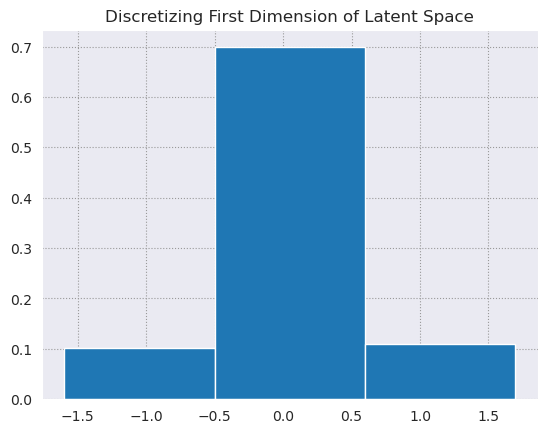

In [428]:
his = plt.hist(RC.Z[:, 0], bins=3, density=True)
plt.title("Discretizing First Dimension of Latent Space")

#plt.savefig("Discrete.png")

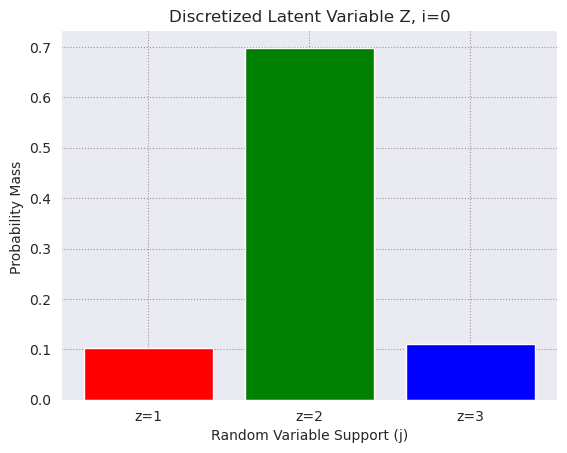

In [434]:
import matplotlib.pyplot as plt

# Step 1: Prepare your data
labels = ['z=1', 'z=2', 'z=3']
bar_heights = [0.10199977, 0.69851631, 0.11019618]
colors = ['red', 'green', 'blue']
# Step 3: Create the bar graph
plt.bar(labels, bar_heights, color=colors)

# Optional: Customize the appearance of the plot
plt.xlabel('Random Variable Support (j)')
plt.ylabel('Probability Mass ')
plt.title('Discretized Latent Variable Z, i=0')
plt.grid(True)

# Step 4: Show the plot
plt.savefig("discrete.png")

In [429]:
his

(array([0.10199977, 0.69851631, 0.11019618]),
 array([-1.59825182, -0.50021017,  0.59783149,  1.69587314]),
 <BarContainer object of 3 artists>)

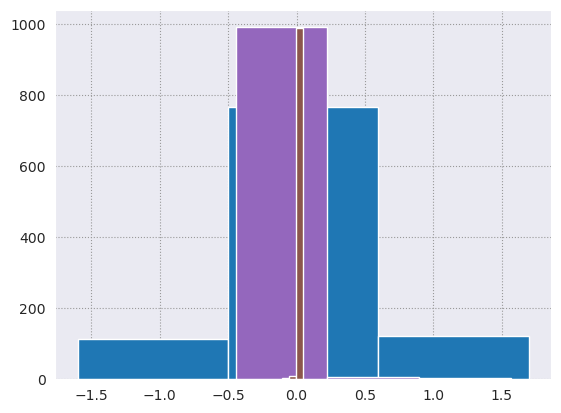

In [418]:
RC = RepresentationCausality(L_final)

In [419]:
RC.PS(i=0, j=1, y=1)

(0, 0)

In [415]:
RC.z_space

{0: {'intervals': [(-1.5982518196105957, -0.500210165977478),
   (-0.500210165977478, 0.5978314876556396),
   (0.5978314876556396, 1.6958731412887573)],
  'pmf': array([0.112, 0.767, 0.121])},
 1: {'intervals': [(-0.04755457490682602, -0.007572919130325317),
   (-0.007572919130325317, 0.032408736646175385),
   (0.032408736646175385, 0.07239039242267609)],
  'pmf': array([0.035, 0.846, 0.119])},
 2: {'intervals': [(-0.08551353961229324, -0.0409766286611557),
   (-0.0409766286611557, 0.003560279728844762),
   (0.003560279728844762, 0.048097189515829086)],
  'pmf': array([0.003, 0.833, 0.164])},
 3: {'intervals': [(-0.08862291276454926, 0.00017869968723971397),
   (0.00017869968723971397, 0.0889803096652031),
   (0.0889803096652031, 0.17778192460536957)],
  'pmf': array([0.442, 0.513, 0.045])},
 4: {'intervals': [(-0.44306159019470215, 0.22612328827381134),
   (0.22612328827381134, 0.8953081965446472),
   (0.8953081965446472, 1.5644930601119995)],
  'pmf': array([0.99 , 0.007, 0.003])},
 

In [ ]:
for i in range(6):
    for j in range(3):
        for y in range(2):
            a, b = PS(i=i, j=j, y=y)
            print(f"i={i}, j={j}, y={y}, PS={a / b}")

### Define Latent "Perturbation" by discretizing latent variables

In [509]:
Z = L.embeddings_as_tensor()

In [383]:
d1 = Z[:, 0]

(array([350., 525., 125.]),
 array([-0.18502066, -0.0619241 ,  0.06117246,  0.18426901]),
 <BarContainer object of 3 artists>)

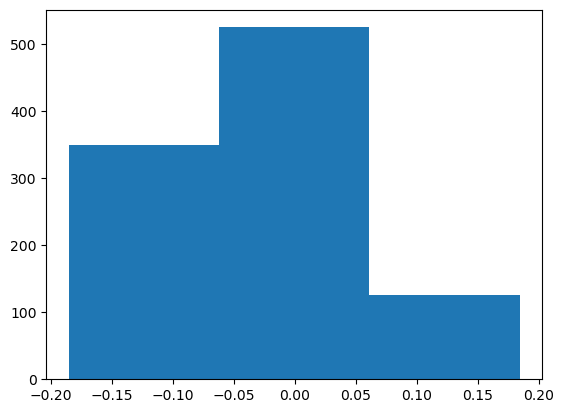

In [432]:
vals = plt.hist(Z[:, 1], bins=3, density=False)
vals

In [435]:
def calc_z_space(Z):
    n_samples, dims = Z.shape
    vals = {}
    for i in range(dims):
        d = {'intervals':[]}
        his = plt.hist(Z[:, i], bins=3)
        d['pmf'] = his[0] / n_samples # probability mass function for categories of Zij
        intervals = his[1]
        d['intervals'].append((intervals[0], intervals[1]))
        d['intervals'].append((intervals[1], intervals[2]))
        d['intervals'].append((intervals[2], intervals[3]))
        vals[i] = d
    return(vals)

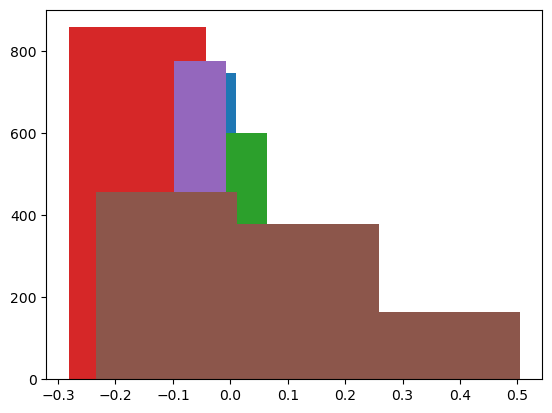

In [436]:
z_space = calc_z_space(Z)

In [459]:
z_space[1]

{'intervals': [(-0.18502065539360046, -0.061924099922180176),
  (-0.061924099922180176, 0.06117245554924011),
  (0.06117245554924011, 0.1842690110206604)],
 'pmf': array([0.35 , 0.525, 0.125])}

In [456]:
L.embeddings[100]

array([ 0.01891517,  0.12566844,  0.0165707 ,  0.36367038, -0.10085335,
        0.28074077], dtype=float32)

In [445]:
def discretized_z(z):
    # using info from z_space, return the discretized version of latent embedding z
    dim = len(z)
    result = np.zeros(dim)
    for i in range(dim):
        zij = z[i] # non discretizd value
        for val, interval in enumerate(z_space[i]['intervals']):
            if(interval[0] <= zij < interval[1]):
                result[i] = val
    return(result)

In [457]:
discretized_z(L.embeddings[100])

array([2., 2., 1., 2., 0., 2.])

In [ ]:
a=[]
for i in range(1000):
    a.append(np.random.uniform(1.73, 2.112))

(array([51., 47., 42., 45., 60., 58., 43., 52., 42., 48., 49., 56., 64.,
        56., 43., 58., 57., 41., 50., 38.]),
 array([1.73017738, 1.7492638 , 1.76835022, 1.78743664, 1.80652306,
        1.82560948, 1.8446959 , 1.86378232, 1.88286874, 1.90195516,
        1.92104158, 1.940128  , 1.95921442, 1.97830084, 1.99738727,
        2.01647369, 2.03556011, 2.05464653, 2.07373295, 2.09281937,
        2.11190579]),
 <BarContainer object of 20 artists>)

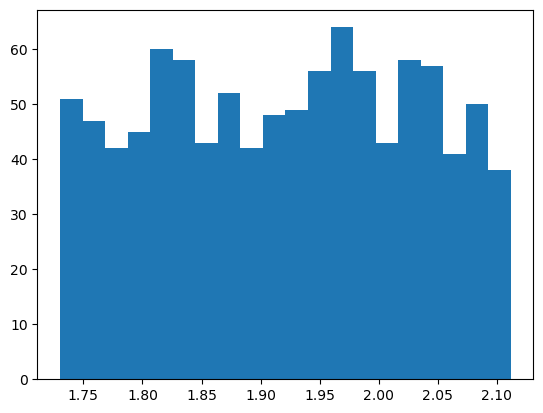

In [ ]:
plt.hist(a)

In [485]:
zp = z.copy()

In [499]:
def force_z(z, i, j):
    # input z: existing embedding that we observe
    # returns altered latent embedding if we force dimension i to take value j
    # this will be used to calculate counterfactual Y(Zi = zij) where i is dimension, j in {1,2,3} is value
    h = z.copy()
    dz = discretized_z(z)
    if(dz[i] == j):
        print("Value already taken, no change")
        return(z)
    interval = z_space[i]['intervals'][j]
    h[i] = np.random.uniform(interval[0], interval[1])
    return(h)

In [500]:
z = L.embeddings[54]
z

array([-0.08482142, -0.09661803, -0.04570893, -0.19170031, -0.05941162,
       -0.05131179], dtype=float32)

In [501]:
discretized_z(z)

array([1., 0., 0., 0., 1., 0.])

In [502]:
%%time
force_z(z, 2, 1)

CPU times: user 74 µs, sys: 29 µs, total: 103 µs
Wall time: 94.4 µs


array([-0.08482142, -0.09661803,  0.03720602, -0.19170031, -0.05941162,
       -0.05131179], dtype=float32)

In [475]:
z_space[4]['intervals']

[(-0.18845051527023315, -0.09783869981765747),
 (-0.09783869981765747, -0.007226884365081787),
 (-0.007226884365081787, 0.0833849310874939)]

### Use Forcing and KNN to calculate Y(Z=z)

In [513]:
def embedding(i):
    return(L.embeddings[i])

In [525]:
Z

tensor([[ 0.0016, -0.0241,  0.0630, -0.1612, -0.1411,  0.2404],
        [ 0.0449, -0.0058,  0.0812, -0.1076, -0.1454,  0.2904],
        [-0.0902, -0.0267, -0.0261, -0.2246, -0.0536,  0.0545],
        ...,
        [ 0.0992,  0.0794,  0.0271,  0.1273, -0.0838,  0.3251],
        [-0.0385, -0.0192,  0.0242, -0.1317, -0.0928,  0.1536],
        [-0.0024,  0.1143, -0.0010,  0.1207, -0.0176,  0.2140]])

In [505]:
kdtree = scipy.spatial.cKDTree(Z, leafsize=16)

In [543]:
%%time
kdtree.query(np.array([0.0, -0.08, 0.12, 0.08, -0.12, -0.7]), k=2, p=np.inf, distance_upper_bound=1.0)

CPU times: user 427 µs, sys: 0 ns, total: 427 µs
Wall time: 389 µs


(array([0.46644409, 0.47722654]), array([30, 58]))

In [545]:
L.embeddings[30]

array([-0.129797  , -0.16974509, -0.06962486, -0.18001981,  0.02983433,
       -0.23355591], dtype=float32)

In [537]:
L.embeddings[115]

array([-9.1017917e-02, -5.6039453e-02,  9.5084310e-05, -2.2514465e-01,
       -5.2338928e-02, -1.3000039e-02], dtype=float32)

In [625]:
kdtree = scipy.spatial.cKDTree(L.embeddings_as_tensor(), leafsize=16)
def Y_force(z_index, i, j):
    # best approximation for counterfactual Y(Z=z), the value y would take if Z was forced to take z
    # first, use above to do the forcing. Then to find counterfactual, find closest existing data point
    # then get ground truth of that point (X, Y) to return the Y
    z = L.embeddings[z_index]
    zf = force_z(z, i, j)
    distance, index = kdtree.query(zf, k=1, p=np.inf, distance_upper_bound=0.3)
    x, y = L.dataset[index]
    y = y.cpu().detach().numpy()
    # NEED TO FIX NORM BUG of dataset since doing universally; should be fixed,check
    return(y * ds_sigma[-43:] + ds_mu[-43:], index)

In [626]:
y, ind = Y_force(115, 0, 2)
y

array([2.07304537e-06, 2.12263762e-06, 1.87788603e-06, 9.16790472e-07,
       4.13775563e-06, 3.30968959e-05, 9.88391625e-05, 3.00318897e-04,
       6.81097463e-04, 1.12467050e-03, 2.67712695e-03, 4.59469924e-03,
       7.75663185e-03, 9.15554240e-03, 9.88417919e-03, 1.00359561e-02,
       1.01494011e-02, 1.02071660e-02, 1.03229092e-02, 1.05401974e-02,
       2.60167388e+02, 2.36683159e+02, 2.15468343e+02, 1.90183981e+02,
       1.99759113e+02, 2.23482406e+02, 2.30449737e+02, 2.39004374e+02,
       2.51091680e+02, 2.58583251e+02, 2.67817856e+02, 2.72693176e+02,
       2.79274959e+02, 2.83483864e+02, 2.89672097e+02, 2.93290804e+02,
       2.97762418e+02, 3.00314257e+02, 3.03890083e+02, 3.07072404e+02,
       2.44964710e+02, 4.32837010e+02, 1.03269611e-09])

In [ ]:
np.round(embedding(115), 2)

array([-0.09, -0.06,  0.  , -0.23, -0.05, -0.01], dtype=float32)

In [571]:
get_item_value(Y_train_xarr, 923, 'out_cam_out_PRECC')

<xarray.DataArray 'out_cam_out_PRECC' ()>
array(-0.40265202)
Coordinates:
    time     object 0006-03-01 12:00:00
    ncol     int64 27
    lat      float64 -5.41
    lon      float64 16.89

In [588]:
y

array([ 8.90778809e-07,  2.04550504e-06,  2.05235260e-06,  3.12430964e-07,
        6.54281771e-06,  8.40822413e-05,  5.93973833e-05,  2.05544124e-05,
       -4.54515085e-05, -4.07338438e-05,  3.75842455e-03,  5.71674411e-03,
        8.37365251e-03,  9.43444907e-03,  9.66182661e-03,  9.40262430e-03,
        8.97420044e-03,  8.67820556e-03,  8.51477478e-03,  8.70817402e-03,
        2.77258808e+02,  2.38775621e+02,  2.03793130e+02,  1.87330957e+02,
        1.98775818e+02,  2.25800712e+02,  2.35960493e+02,  2.44422150e+02,
        2.56544019e+02,  2.64888158e+02,  2.65996013e+02,  2.71200514e+02,
        2.77928768e+02,  2.83681223e+02,  2.93312201e+02,  2.99041628e+02,
        3.06197094e+02,  3.10591439e+02,  3.16851804e+02,  3.22329345e+02,
        1.80581941e+02,  4.58948102e+02,  2.26724289e-09])

### Estimate Probability of Necessity and Sufficiency

In [590]:
selected_levels

array([ 4,  8, 12, 16, 20, 24, 26, 28, 31, 33, 36, 38, 41, 43, 46, 48, 51,
       53, 56, 59], dtype=int32)

In [614]:
L.dataset.ds # train

<xarray.Dataset>
Dimensions:            (time: 1095, ncol: 32, lev: 20)
Coordinates:
  * time               (time) object 0006-02-01 12:00:00 ... 0009-01-31 12:00:00
  * ncol               (ncol) int64 0 1 2 3 4 5 6 7 ... 24 25 26 27 28 29 30 31
    lat                (ncol) float64 -32.59 -35.99 -22.69 ... -13.3 -5.01 -4.43
    lon                (ncol) float64 -39.73 -28.47 -39.56 ... 39.46 28.15 39.4
Dimensions without coordinates: lev
Data variables:
    state_q0001        (time, lev, ncol) float64 0.6494 0.6424 ... 1.065 1.001
    state_t            (time, lev, ncol) float64 0.2371 0.3409 ... 0.507 0.8147
    pbuf_SOLIN         (time, ncol) float64 1.037 1.02 1.027 ... 0.7693 0.7555
    pbuf_LHFLX         (time, ncol) float64 -0.09068 -0.1706 ... 0.0583 0.06364
    pbuf_SHFLX         (time, ncol) float64 -0.6119 -0.5323 ... -0.4645 0.4236
    state_ps           (time, ncol) float64 0.4631 0.5052 0.1 ... -1.446 -0.8282
    out_state_q0001    (time, lev, ncol) float64 0.6494 0.6424 ... 1.064 1.003
    out_state_t        (time, lev, ncol) float64 0.2396 0.3435 ... 0.5035 0.8175
    out_cam_out_NETSW  (time, ncol) float64 1.916 1.488 0.751 ... -0.5248 0.1089
    out_cam_out_FLWDS  (time, ncol) float64 0.1372 0.12 0.7583 ... 0.783 0.9532
    out_cam_out_PRECC  (time, ncol) float64 -0.4161 -0.4051 ... 1.823 -0.4114

In [ ]:
get_item_value(L.dataset.ds, 923, 

In [660]:
# given the index, determine whether output vector Y_i=y by using binary threshold
def Yequalsy(index, outvar, y, level=59, threshold_perc=50):
    # y is binary 0 or 1
    # get Yi, relevant var value
    Yi = get_item_value(L.dataset.ds, index, outvar, level)
    threshold_value = scipy.stats.scoreatpercentile(L.dataset.ds[outvar].values.flatten(), threshold_perc)
    return(int(Yi > threshold_value) == y)
    

In [703]:
kdtree = scipy.spatial.cKDTree(L.embeddings_as_tensor(), leafsize=16)
def Y_force_equals_y(z_index, i, j, y, outvar='out_cam_out_PRECC', level=59, threshold_perc=50):
    # best approximation for counterfactual Y(Z=z), the value y would take if Z was forced to take z
    # first, use above to do the forcing. Then to find counterfactual, find closest existing data point
    # then get ground truth of that point (X, Y) to return the Y
    z = L.embeddings[z_index]
    zf = force_z(z, i, j)
    distance, index = kdtree.query(zf, k=1, p=np.inf, distance_upper_bound=0.3)
    Yi = get_item_value(L.dataset.ds, index, outvar, level) # "counterfactual" variable level
    #print(Yi.item())
    threshold_value = scipy.stats.scoreatpercentile(L.dataset.ds[outvar].values.flatten(), threshold_perc)
    return(int(Yi > threshold_value) == y)

In [677]:
Y_force(943, 2, 1)

Value already taken, no change


(array([2.07332894e-06, 2.09453128e-06, 1.79680876e-06, 1.54514639e-06,
        5.44524307e-06, 1.13336790e-04, 2.83216337e-04, 6.20986677e-04,
        1.42623892e-03, 2.02339224e-03, 3.49298791e-03, 4.69527069e-03,
        6.56996374e-03, 7.93327562e-03, 9.85506660e-03, 1.09097895e-02,
        1.24658632e-02, 1.37084851e-02, 1.54058139e-02, 1.59656570e-02,
        2.56373928e+02, 2.39464353e+02, 2.17738165e+02, 1.89831507e+02,
        1.99131419e+02, 2.24224438e+02, 2.34206903e+02, 2.42641156e+02,
        2.53026743e+02, 2.59609283e+02, 2.68133512e+02, 2.72982226e+02,
        2.78896604e+02, 2.82148439e+02, 2.85737088e+02, 2.87963406e+02,
        2.90748505e+02, 2.92365012e+02, 2.95154775e+02, 2.98542055e+02,
        1.94880119e+02, 4.20002858e+02, 3.10254186e-08]),
 943)

In [685]:
z_space[2]['intervals']

[(-0.12114092707633972, -0.028423601761460304),
 (-0.028423601761460304, 0.06429371982812881),
 (0.06429371982812881, 0.15701104700565338)]

In [686]:
embedding(943)

array([-0.05478957, -0.04018813, -0.00320453, -0.17885165, -0.02828202,
        0.00141372], dtype=float32)

In [696]:
Y_force_equals_y(z_index=943, i=2, j=2, y=0)

-0.4161394001199037


True

In [667]:
scipy.stats.scoreatpercentile(ds['out_cam_out_PRECC'].values.flatten(), 80)

3.075168151031321e-08

In [668]:
Yequalsy(923, 'out_cam_out_PRECC', 0)

True

In [704]:
def PS(i, j, y, outvar='out_cam_out_PRECC', level=59):
    # Probability of Sufficiency
    # Pr that latent variable zi taking value j is sufficient to make outvar take value y
    total = 0 # eventually divide to get total
    count = 0
    for index, z in L.embeddings.items():
        # conditioned on Z neq z, Y neq y, so need to filter
        if(len(z) != 6):
            print("Something is amiss")
        dz = discretized_z(z)
        if(dz[i] != j and not Yequalsy(index, outvar, y)):
           # now that filtered by conditional, see if forcing changes
            total += 1
            count += int(Y_force_equals_y(index, i, j, y, outvar, level)) # increment if forcing changes label
    return(count, total)

In [705]:
PS(i=1, j=1, y=1)

(57, 218)

In [709]:
for i in range(6):
    for j in range(3):
        for y in range(2):
            a, b = PS(i=i, j=j, y=y)
            print(f"i={i}, j={j}, y={y}, PS={a / b}")

i=0, j=0, y=0, PS=0.5401869158878505
i=0, j=0, y=1, PS=0.3103448275862069
i=0, j=1, y=0, PS=0.06382978723404255
i=0, j=1, y=1, PS=0.6363636363636364
i=0, j=2, y=0, PS=0.610204081632653
i=0, j=2, y=1, PS=0.17142857142857143
i=1, j=0, y=0, PS=0.47058823529411764
i=1, j=0, y=1, PS=0.36742424242424243
i=1, j=1, y=0, PS=0.4626865671641791
i=1, j=1, y=1, PS=0.30275229357798167
i=1, j=2, y=0, PS=0.4446601941747573
i=1, j=2, y=1, PS=0.5201793721973094
i=2, j=0, y=0, PS=0.6148796498905909
i=2, j=0, y=1, PS=0.19375
i=2, j=1, y=0, PS=0.3037974683544304
i=2, j=1, y=1, PS=0.503448275862069
i=2, j=2, y=0, PS=0.7873134328358209
i=2, j=2, y=1, PS=0.2570194384449244
i=3, j=0, y=0, PS=0.3191489361702128
i=3, j=0, y=1, PS=0.46875
i=3, j=1, y=0, PS=0.06726457399103139
i=3, j=1, y=1, PS=0.83
i=3, j=2, y=0, PS=0.12030075187969924
i=3, j=2, y=1, PS=0.8038793103448276
i=4, j=0, y=0, PS=0.6534839924670434
i=4, j=0, y=1, PS=0.2564102564102564
i=4, j=1, y=0, PS=0.4117647058823529
i=4, j=1, y=1, PS=0.423645320197